# Deep VIB Experiments by Marco Zeulner

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.init as init
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
import math
import seaborn as sns
import os

In [2]:
# Suppress pandas fragmentation warning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## Helper functions

In [3]:
def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

def get_data_loaders(dataset_name: str, batch_size: int):
    transform = transforms.Compose([transforms.ToTensor()])

    if dataset_name.lower() == 'fashionmnist':
        train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name.lower() == 'mnist':
        train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError("Dataset must be 'MNIST' or 'FashionMNIST'")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, test_loader

def vae_loss(x_recon, x, mu, logvar, beta, model=None):
    mse = nn.functional.mse_loss(x_recon, x, reduction='mean')
    if isinstance(model, VAE_LearnablePrior):
        kl_div = model.get_kl_divergence(mu, logvar).mean()
    else:
        kl_div = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return mse + beta * kl_div, mse, kl_div

def train_one_epoch(model, optimizer, loader, beta, device):
    model.train()
    for x, _ in loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, _, mu, logvar = model(x, num_samples=1)
        loss, _, _ = vae_loss(x_recon, x, mu, logvar, beta, model)
        loss.backward()
        optimizer.step()

@torch.no_grad()
def evaluate(model, loader, beta, device, avg_samples=12):
    model.eval()
    total_kl, total_mse_1_shot, total_mse_avg, total_samples = 0, 0, 0, 0
    for x, _ in loader:
        x = x.to(device)
        batch_size = x.size(0)
        x_recon_1_shot, x_recon_avg, mu, logvar = model(x, num_samples=avg_samples)
        _, mse_1, kl = vae_loss(x_recon_1_shot, x, mu, logvar, beta, model)
        mse_a = nn.functional.mse_loss(x_recon_avg, x, reduction='mean')
        total_kl += kl.item() * batch_size
        total_mse_1_shot += mse_1.item() * batch_size
        total_mse_avg += mse_a.item() * batch_size
        total_samples += batch_size
    return {'i_x_z': total_kl / total_samples, 'mse_1_shot': total_mse_1_shot / total_samples, 'mse_avg': total_mse_avg / total_samples}

def get_beta_values():
    beta_exponents = range(-9, 2)
    beta_values = [math.pow(10, exp) for exp in beta_exponents]
    return beta_values

## Relevant classes

In [4]:
class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size
    def forward(self, tensor):
        return tensor.view(self.size)



class VAE_CNN(nn.Module):
    def __init__(self, k_dim=10, nc=1):
        super(VAE_CNN, self).__init__()
        self.k_dim = k_dim
        self.nc = nc

        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 32, 4, 2, 1),          # B,  32, 14, 14
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),          # B,  64,  7,  7
            nn.ReLU(True),
            nn.Conv2d(64, 256, 7, 1, 0),         # B, 256,  1,  1
            nn.ReLU(True),
            View((-1, 256*1*1)),                 # B, 256
            nn.Linear(256, k_dim * 2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(k_dim, 256),               # B, 256
            View((-1, 256, 1, 1)),               # B, 256,  1,  1
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 64, 7, 1, 0), # B,  64,  7,  7
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # B,  32, 14, 14
            nn.ReLU(True),
            nn.ConvTranspose2d(32, nc, 4, 2, 1),  # B,  nc, 28, 28
            nn.Sigmoid()
        )
        self.weight_init()

    def weight_init(self):
        for m in self._modules.values():
            if isinstance(m, nn.Sequential):
                for sub_m in m: kaiming_init(sub_m)
            else: kaiming_init(m)

    def forward(self, x, num_samples=1):
        distributions = self.encoder(x)
        mu, logvar = distributions.chunk(2, dim=1)
        recons = torch.stack([self.decoder(reparameterize(mu, logvar)) for _ in range(num_samples)])
        x_recon_avg = torch.mean(recons, dim=0)
        x_recon_1_shot = recons[0]
        return x_recon_1_shot, x_recon_avg, mu, logvar

class VAE_LearnablePrior(VAE_CNN):
    def __init__(self, k_dim=10, nc=1):
        super(VAE_LearnablePrior, self).__init__(k_dim=k_dim, nc=nc)
        self.prior_mu = nn.Parameter(torch.zeros(k_dim))
        self.prior_logvar = nn.Parameter(torch.zeros(k_dim))

    def get_kl_divergence(self, mu, logvar):
        var = logvar.exp()
        prior_var = self.prior_logvar.exp()
        term1 = (var / prior_var).sum(dim=1)
        term2 = (((mu - self.prior_mu) ** 2) / prior_var).sum(dim=1)
        log_det_ratio = (self.prior_logvar - logvar).sum(dim=1)
        return 0.5 * (term1 + term2 + log_det_ratio - mu.size(1))

## Plotting functions

In [5]:
@torch.no_grad()
def plot_latent_space_comparison(static_model, learnable_model, loader, device, beta_val, dataset_name):
    static_model.eval()
    learnable_model.eval()

    latents = {'static': [], 'learnable': []}
    labels_all = []
    for i, (x, y) in enumerate(loader):
        if i > 20: break
        x_dev = x.to(device)
        _, _, mu_s, logvar_s = static_model.forward(x_dev)
        _, _, mu_l, logvar_l = learnable_model.forward(x_dev)
        latents['static'].append(torch.cat([mu_s, logvar_s], dim=1).cpu())
        latents['learnable'].append(torch.cat([mu_l, logvar_l], dim=1).cpu())
        labels_all.append(y)

    labels = torch.cat(labels_all, dim=0).numpy()

    if dataset_name.lower() == 'fashionmnist':
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    else:
        class_names = [f'Digit {i}' for i in range(10)]

    fig, axes = plt.subplots(1, 2, figsize=(24, 12))
    fig.suptitle(f'Latent Space Comparison for {dataset_name} (K=2, β={beta_val:.2e})', fontsize=20)

    model_names = ['static', 'learnable']
    for i, ax in enumerate(axes):
        model_name = model_names[i]
        mu = torch.cat(latents[model_name], dim=0)[:, :2].numpy()
        logvar = torch.cat(latents[model_name], dim=0)[:, 2:].numpy()
        var = np.exp(logvar)

        print(f"--> Plotting {mu.shape[0]} data points for the {model_name.capitalize()} model.")

        cmap = plt.get_cmap('tab10')
        for c_idx in range(10):
            idx = labels == c_idx
            ax.scatter(mu[idx, 0], mu[idx, 1], c=[cmap(c_idx)], label=class_names[c_idx], alpha=0.5, s=15)

        ax.set_xlabel('Latent Dimension 1', fontsize=14)
        ax.set_ylabel('Latent Dimension 2', fontsize=14)
        ax.set_title(f'Model: {model_name.capitalize()} Prior', fontsize=16)
        ax.legend(); ax.grid(True)
        ax.set_aspect('equal', adjustable='box')

    plt.show()

@torch.no_grad()
def plot_aggregated_posterior_vs_priors(model, loader, device, beta_val, dataset_name):
    if not isinstance(model, VAE_LearnablePrior) or model.k_dim != 2:
        return
    model.eval()

    # First i need to extract the aggregated posterior means
    all_mus = []
    for i, (x, _) in enumerate(loader):
        if i > 40: break
        _, _, mu, _ = model.forward(x.to(device))
        all_mus.append(mu.cpu())
    aggregated_mus = torch.cat(all_mus, dim=0).numpy()

    # Then the learned prior parameters
    learned_mu = model.prior_mu.detach().cpu().numpy()
    learned_var = torch.exp(model.prior_logvar).detach().cpu().numpy()

    # Preparing the plot using a robust 2D Histogram
    fig, ax = plt.subplots(figsize=(13, 12))

    h = ax.hist2d(aggregated_mus[:, 0], aggregated_mus[:, 1], bins=60, cmap="Greys", density=True)
    fig.colorbar(h[3], ax=ax, label='Density of Latent Means')
    ax.set_title(f'Aggregated Posterior vs. Priors for {dataset_name} (K=2, β={beta_val:.2e})', fontsize=16)

    # Overlay the prior contours
    static_prior_ellipse = Ellipse(xy=(0, 0), width=2, height=2, angle=0, edgecolor='red', facecolor='none', lw=3, linestyle='--', label='Static Prior N(0,1)')
    ax.add_patch(static_prior_ellipse)

    eigenvalues, eigenvectors = np.linalg.eigh(np.diag(learned_var))
    angle = np.degrees(np.arctan2(*eigenvectors[:,0][::-1]))
    width, height = 2 * np.sqrt(2.30 * eigenvalues)
    learned_prior_ellipse = Ellipse(xy=learned_mu, width=width, height=height, angle=angle, edgecolor='cyan', facecolor='none', lw=3, linestyle='-', label='Learned Prior')
    ax.add_patch(learned_prior_ellipse)

    # The markers for the means:
    agg_posterior_mean = aggregated_mus.mean(axis=0)

    # Plot marker for the Static Prior mean (at 0,0)
    ax.scatter(0, 0, marker='P', color='red', s=300, label='Mean of Static Prior', zorder=10, edgecolor='white')

    # Plot marker for the Learned Prior mean
    ax.scatter(learned_mu[0], learned_mu[1], marker='*', color='cyan', s=400, label='Mean of Learned Prior', zorder=10, edgecolor='black')

    # Plot marker for the Aggregated Posterior mean
    ax.scatter(agg_posterior_mean[0], agg_posterior_mean[1], marker='X', color='white', s=250, label='Mean of Agg. Posterior', zorder=10, edgecolor='black')
    # ------------------------------------

    ax.set_xlabel('Latent Dimension 1', fontsize=14)
    ax.set_ylabel('Latent Dimension 2', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)
    ax.set_aspect('equal', adjustable='box')
    plt.show()

## The main experiment part

Using device: cuda

==================== Running Experiment for: MNIST ====================


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.4MB/s]
Dataset=MNIST, K=256, Model=learnable:   0%|          | 0/11 [00:00<?, ?it/s]


  Final Learned Prior (K=256, β=1.0e-09) -> Mu: [-0.27  0.37  0.36 -0.34  0.61  0.65  0.1  -0.29 -0.94 -0.31  0.83  0.21
 -0.2   0.04  0.25  0.28 -0.06  0.42 -0.52  0.08 -0.15  0.55 -0.14  0.08
  0.77 -0.03  0.34  0.49  0.01  0.4  -0.53 -0.16 -0.17 -0.04  0.08 -0.49
 -0.6  -0.12  0.25 -0.51  0.67 -0.52  0.48  0.79 -0.39 -0.68 -0.02  0.76
 -0.78  0.76 -0.5   0.02  0.01  0.16  0.42  0.52 -0.05  0.62  0.15  0.02
  0.2   0.09  0.16 -0.33  0.48  0.24 -0.19 -0.94 -0.77 -0.29 -0.09 -0.22
 -0.56  0.07 -0.72  0.34 -1.08  0.22  0.77 -0.14 -0.11  0.26 -0.14 -0.13
  0.28 -0.56 -0.01 -0.48  0.12  0.17 -0.41 -0.72  0.01 -0.14  0.28 -0.17
 -0.09 -0.59 -0.36 -0.09 -0.04  0.81  0.2  -1.03  0.64 -0.16  0.68 -0.12
 -0.06 -0.28 -0.55 -0.   -0.27 -0.08 -0.23 -0.09 -0.92 -0.09 -0.65 -0.4
 -0.35  0.08 -0.34 -0.61  0.26  0.86 -0.36  0.5  -0.23  0.4   0.14 -0.42
  0.35 -0.8  -0.44 -0.45 -0.24 -0.14  0.12 -0.6   0.05 -0.05  0.71 -0.07
  0.1  -0.48 -0.34 -0.06 -0.11  0.18  0.08  0.83 -0.07  0.21 -0.65  0.24
  0

Dataset=MNIST, K=256, Model=learnable:   9%|▉         | 1/11 [02:40<26:41, 160.17s/it]


  Final Learned Prior (K=256, β=1.0e-08) -> Mu: [ 0.81 -1.23 -0.06 -0.98  1.78  1.6   1.25 -0.78  1.67 -1.16 -1.34  0.4
  0.05  0.1   0.11 -0.31 -0.72  1.37  0.16 -0.91  1.34  0.08  1.53  0.76
  1.19 -1.48  0.26  0.02  0.81  0.74  0.96 -0.37 -0.9   0.98  1.35 -1.29
 -0.86 -0.61 -0.52  0.28 -0.44 -0.01  1.98 -0.71 -0.77 -0.91 -1.44  1.8
  0.83 -1.53  0.27 -1.97 -0.65 -1.66 -1.69 -0.86  1.11 -0.45 -0.52 -0.95
  0.58 -0.97  0.35 -1.64 -0.44  0.15 -0.79 -2.02  1.08  0.51 -0.73  1.92
 -1.67  0.01 -0.67  1.08  0.4  -1.91 -0.26  1.95  0.52  0.95  1.03 -0.01
 -0.8   0.95  0.36 -1.32 -1.61  0.2   0.82  1.23  0.01  1.    0.4   1.39
 -1.54  0.45  1.67  1.96  2.16  0.4  -1.04 -1.92 -1.83 -2.07  1.64 -0.3
  1.29  1.47  0.12  1.64  2.15 -0.01 -1.8  -0.75  0.36 -0.03  1.65 -1.09
 -0.49  0.66 -1.23 -0.08  1.21 -0.23 -0.43 -1.9   1.08  0.18 -0.83  1.73
 -1.87 -0.11  0.71 -0.37  1.72 -0.48 -1.83 -1.77 -0.08 -0.97 -0.57  1.31
  1.23 -2.1  -0.99 -0.04 -0.29 -0.15 -0.72 -0.35 -0.87 -0.07  0.89  0.12
 -0.1

Dataset=MNIST, K=256, Model=learnable:  18%|█▊        | 2/11 [05:19<23:58, 159.83s/it]


  Final Learned Prior (K=256, β=1.0e-07) -> Mu: [-1.42 -0.82 -0.1   1.34 -0.06  1.18 -0.48  1.99 -0.98 -1.71 -0.38 -1.12
 -0.27 -2.47  1.81 -0.62 -1.5   1.63  0.09 -1.32  0.88  1.03 -2.17  1.21
 -0.03 -1.2  -0.85 -0.16  0.83  1.92  1.08  0.99  1.86  0.24  0.38  0.87
  1.68 -0.39 -0.1  -0.39  0.26 -0.02 -2.04  1.63  1.26  1.57 -0.31 -1.79
 -0.55 -0.04  1.18  0.92 -0.3  -2.23  0.35  0.25  0.26  0.02  0.17 -1.95
  1.3   0.19 -0.42  1.63  2.36  2.49  0.36 -1.48  1.55 -2.37  0.79  0.15
 -1.54  1.47 -1.27 -0.65 -0.45  2.06  1.11  1.84  1.55 -0.38 -0.38 -0.89
 -0.33  2.09 -1.   -0.58 -0.51 -1.64 -1.34  0.49 -0.57 -1.41 -1.45 -0.14
 -2.25  1.06 -1.03 -0.22  2.39  0.46  1.45 -0.65 -0.88  0.15 -0.38  1.17
  0.25 -1.61  0.47  0.12 -0.84  0.39  0.2   1.79  1.19  0.12 -1.18 -1.24
 -0.43  0.35 -0.52 -1.38  1.06 -0.55 -0.07  1.5  -0.38 -0.15 -1.22  0.94
  0.94  0.46 -0.52 -1.25 -1.36 -1.63 -0.14 -0.91  0.12  1.27 -0.05 -0.35
 -1.87  0.48 -1.1   0.74  0.93  1.45 -2.32 -1.45  1.47 -1.24 -1.24  1.72
  

Dataset=MNIST, K=256, Model=learnable:  27%|██▋       | 3/11 [07:59<21:18, 159.76s/it]


  Final Learned Prior (K=256, β=1.0e-06) -> Mu: [-0.15 -1.11  0.3   0.83 -1.08  0.33 -0.17  0.6  -0.67 -0.54 -0.16  0.2
 -0.15  0.11  0.   -0.93  0.23 -0.91 -0.38  0.1  -0.35 -1.44 -1.18  0.38
  1.29 -0.36  0.67  0.78 -0.58 -0.9  -1.08  0.96  0.   -0.44 -0.13 -0.93
  1.3  -0.35  0.39  0.07 -1.29 -0.99 -0.45  0.59  0.62  0.32 -0.37 -0.21
 -1.26 -0.51  1.13 -0.31 -0.16 -0.14 -0.69 -0.82  0.13  0.82 -0.7  -0.31
 -0.02  1.26  0.45 -0.33 -1.05  0.43  0.98 -0.75  0.18 -1.07  0.69  0.66
  0.38 -0.28  0.81 -0.93 -0.44  0.63  0.41 -1.44 -0.01 -0.13 -0.22  0.55
  1.3  -0.21  1.21 -0.41  1.42  0.42 -0.16 -0.57  0.4  -0.7  -1.26 -0.04
 -0.61  0.06  0.12  0.7   1.15 -0.19  1.28 -0.81  0.09  1.01 -0.21 -0.73
  0.17 -0.3   1.23  0.86 -0.05  0.4  -0.28 -0.78  0.99  0.04  0.04 -0.58
  0.4  -0.16 -0.58  0.07 -0.17 -0.72 -1.19 -0.95  0.19  1.11  0.51 -0.33
  0.13 -0.42  0.03 -0.33 -0.92 -1.06  0.12 -0.27  0.04  0.37 -0.05  0.47
 -1.14  0.02 -0.62 -1.08 -0.26 -0.84 -0.64  1.02 -0.92  0.96 -0.15 -0.8
 -0.

Dataset=MNIST, K=256, Model=learnable:  36%|███▋      | 4/11 [10:38<18:36, 159.47s/it]


  Final Learned Prior (K=256, β=1.0e-05) -> Mu: [-0.54 -0.59  0.33  0.08  0.92 -0.2  -0.05 -0.62  0.9   0.19 -0.98  0.97
 -0.43 -0.93  0.38  0.27  0.25 -1.31 -1.06 -0.48  0.04 -0.25 -0.17  0.27
 -0.14 -0.55  0.64 -0.44 -0.83 -0.34  0.27  1.12 -0.04  0.09 -0.7  -0.13
  0.08  0.38 -0.07  0.95 -0.24 -0.6   1.04 -0.78  0.25  0.63  0.91 -0.32
 -0.42  0.15 -0.8  -1.58 -0.59  0.1  -0.94  0.49  0.73  0.14  0.16 -0.02
  0.67 -0.88 -0.05 -0.73 -1.22  0.37 -0.32  0.04 -0.56 -0.27 -0.69 -0.31
  0.77  0.71  0.96  0.16 -0.24  0.17  0.01  1.1  -0.21  0.8   0.    0.72
 -0.86  0.14 -0.03 -0.37 -1.19  0.16  0.01 -0.53  0.09 -1.23 -0.64 -1.43
 -0.69 -0.67 -1.14  0.56 -0.05 -0.36  1.06 -1.13 -1.31 -0.68 -0.81 -0.05
  0.59 -0.47 -0.75 -0.4   0.28 -0.08  0.67  0.37 -0.07  0.77  0.9   0.75
 -0.03  0.29  0.93 -0.89 -0.03 -0.07 -0.69  0.41 -0.55 -0.17 -1.   -0.02
 -0.09 -0.38 -0.11  0.01  0.47 -0.38  0.71  0.24  0.63  0.34 -0.06 -0.55
  0.76 -0.16  0.3   0.79 -0.86 -1.1  -1.02  0.7  -0.05  0.28 -0.26  0.5
 -0

Dataset=MNIST, K=256, Model=learnable:  45%|████▌     | 5/11 [13:20<16:01, 160.23s/it]


  Final Learned Prior (K=256, β=1.0e-04) -> Mu: [ 0.38 -0.33 -0.02  0.83  0.15 -0.13  0.7   0.23  0.88 -0.25  0.13 -0.6
  0.37 -0.13  0.1   0.45  0.79  0.05  0.61  0.27 -0.29 -0.42  0.1   0.09
 -0.7  -0.84  0.36  0.19 -0.19  0.05 -0.03  0.59 -0.08  0.14  0.56 -0.18
  0.61 -0.29 -0.5  -0.02  0.42  0.48 -1.06  0.15  0.13  0.08  0.31  0.42
  0.45 -0.64 -0.89  1.03 -0.32 -0.56 -1.14  0.56 -0.09  0.7  -0.29 -0.54
 -0.28  0.53  0.25 -0.38  0.97  0.31 -0.67 -0.37 -0.   -0.68  0.06  0.49
  0.84 -0.03  1.28 -0.23  0.07 -0.37  0.39 -0.06 -0.14 -0.35 -0.2  -0.22
 -0.22  0.71 -0.34 -0.06 -1.25  0.03 -0.65 -0.46  0.03 -0.03 -0.52 -0.12
 -0.32 -0.59  1.06 -0.25 -0.13 -0.4  -0.09  0.14 -0.47 -0.32 -0.21  0.54
  0.56  0.89 -0.31  1.22  0.38 -0.4   0.48  0.42  0.67  0.49  0.6  -0.02
  0.1   0.63  0.13 -0.13  0.08  0.91  0.2  -0.18  0.28 -0.96  0.35  0.03
 -0.13  0.25  0.07  0.05  0.07 -0.16 -0.35 -1.03 -0.03  1.1  -0.14 -0.26
  0.18 -0.48 -0.79 -0.76 -0.3   0.5   0.48  0.44  0.1  -0.83  0.3  -0.06
  0

Dataset=MNIST, K=256, Model=learnable:  55%|█████▍    | 6/11 [16:00<13:21, 160.23s/it]


  Final Learned Prior (K=256, β=1.0e-03) -> Mu: [-0.05 -0.17  0.04 -0.17  0.17  0.19 -0.06 -0.17  0.55 -0.19  0.22 -0.12
 -0.22  0.16  0.2  -0.15  0.15  0.06  0.16 -0.23  0.15  0.08  0.25  0.24
  0.01 -0.29 -0.19  0.22  0.17 -0.07 -0.16 -0.14  0.09  0.22  0.13  0.13
 -0.14 -0.03  0.2  -0.12 -0.05  0.09  0.15 -0.11  0.07  0.07  0.1   0.13
 -0.04 -0.2  -0.12 -0.21  0.01  0.17  0.16 -0.17  0.17  0.07  0.22 -0.19
  0.03  0.05 -0.04  0.14  0.03 -0.16 -0.08 -0.03 -0.06  0.17  0.12 -0.02
 -0.06  0.02 -0.01 -0.2   0.1   0.07 -0.07  0.17 -0.13 -0.15  0.17 -0.18
 -0.03  0.03 -0.06  0.12  0.07 -0.05 -0.04  0.21  0.05 -0.2   0.01 -0.16
 -0.02  0.13 -0.22  0.18  0.02 -0.23 -0.13  0.2  -0.24 -0.14  0.03  0.19
  0.09  0.22 -0.05 -0.23  0.06  0.23 -0.1  -0.13  0.18 -0.   -0.    0.15
 -0.15  0.22 -0.05  0.01 -0.18 -0.18  0.    0.05 -0.04  0.23 -0.21  0.11
  0.16 -0.19  0.14  0.14  0.06 -0.04 -0.19 -0.08 -0.1  -0.23 -0.23  0.01
  0.07  0.01  2.43 -0.17 -0.18 -0.15  0.11 -0.15  0.13 -0.15  0.02  0.14
  

Dataset=MNIST, K=256, Model=learnable:  64%|██████▎   | 7/11 [18:39<10:39, 159.97s/it]


  Final Learned Prior (K=256, β=1.0e-02) -> Mu: [-0.    0.    0.   -0.01  0.01  0.    0.01  0.    0.    0.   -0.01  0.
  0.   -0.    0.    0.    0.   -0.   -0.   -0.01 -0.    0.    0.01  0.
  0.01 -0.    0.   -0.02  0.   -0.    0.    0.01 -0.   -0.01 -0.    0.
  0.   -0.01 -0.01 -0.    0.01  0.   -0.    0.    0.    0.01 -0.    0.
  0.   -0.    0.    0.   -0.   -0.    0.    0.    0.    0.   -0.01 -0.
 -0.   -0.    0.    0.   -0.   -0.    0.    0.   -0.   -0.   -0.01  0.
 -0.    0.   -0.   -0.   -0.   -0.    0.    0.    0.01 -0.   -0.01  0.01
 -0.    0.    0.   -0.   -0.   -0.    0.    0.    0.    0.   -0.    0.
 -0.   -0.    0.01  0.   -0.   -0.    0.   -0.    0.   -0.   -0.    0.
 -0.01 -0.01 -0.    0.    0.01 -0.    0.   -0.    0.   -0.01 -0.    0.
  0.    0.   -0.   -0.   -0.    0.   -0.    0.   -0.   -0.   -0.    0.
 -0.    0.   -0.01 -0.    0.    0.01 -0.   -0.    0.    0.    0.01 -0.
  0.01  0.01  0.   -0.    0.01  0.    0.   -0.    0.    0.    0.    0.
 -0.    0.   -0.    0.   -

Dataset=MNIST, K=256, Model=learnable:  73%|███████▎  | 8/11 [21:19<07:59, 159.99s/it]


  Final Learned Prior (K=256, β=1.0e-01) -> Mu: [ 0. -0. -0. -0.  0. -0.  0. -0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0. -0. -0. -0.  0. -0.  0.  0.
 -0. -0.  0.  0.  0. -0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0. -0. -0.
  0. -0. -0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0.  0.  0.  0.  0. -0.
 -0. -0. -0.  0.  0.  0. -0. -0.  0. -0. -0. -0.  0.  0.  0. -0. -0. -0.
 -0. -0. -0. -0. -0.  0.  0. -0. -0. -0.  0. -0.  0. -0. -0.  0. -0. -0.
  0.  0.  0. -0. -0.  0. -0. -0. -0. -0. -0.  0. -0. -0.  0. -0. -0.  0.
  0. -0.  0. -0.  0. -0.  0. -0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0.
  0.  0.  0. -0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0.
 -0. -0.  0. -0.  0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0.  0. -0. -0.
  0. -0. -0.  0. -0. -0.  0.  0.  0. -0.  0.  0.  0. -0.  0. -0. -0. -0.
 -0. -0.  0. -0.  0.  0.  0.  0.  0. -0. -0. -0.  0. -0.  0.  0. -0.  0.
 -0.  0.  0.  0.  0. -0. -0. -0.  0. -0.  0. -0. -0.  0.  0. -0.  0. -0.
 -

Dataset=MNIST, K=256, Model=learnable:  82%|████████▏ | 9/11 [23:59<05:19, 159.82s/it]


  Final Learned Prior (K=256, β=1.0e+00) -> Mu: [-0.  0.  0. -0. -0. -0.  0. -0. -0. -0.  0. -0. -0.  0.  0. -0.  0. -0.
 -0. -0.  0. -0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0. -0. -0.
  0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0.
  0. -0. -0.  0.  0. -0.  0. -0. -0. -0. -0.  0. -0.  0.  0.  0.  0.  0.
 -0.  0. -0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0.  0.
 -0.  0. -0.  0. -0.  0. -0.  0.  0.  0.  0.  0. -0. -0. -0.  0. -0. -0.
 -0.  0. -0. -0.  0. -0. -0. -0.  0.  0.  0.  0.  0. -0.  0.  0. -0.  0.
 -0. -0.  0. -0.  0.  0.  0. -0.  0. -0.  0.  0. -0. -0. -0. -0.  0.  0.
  0.  0.  0.  0. -0.  0. -0. -0. -0. -0.  0. -0.  0. -0. -0. -0.  0.  0.
  0. -0.  0. -0.  0.  0.  0.  0. -0.  0.  0. -0.  0. -0.  0. -0.  0.  0.
 -0. -0. -0. -0.  0.  0. -0.  0. -0.  0. -0.  0.  0.  0.  0.  0. -0. -0.
  0. -0. -0.  0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0.  0.  0.  0.  0.
  0.  0. -0.  0.  0.  0.  0. -0. -0.  0.  0. -0. -0. -0. -0.  0. -0.  0.
 -

Dataset=MNIST, K=256, Model=learnable:  91%|█████████ | 10/11 [26:37<02:39, 159.46s/it]


  Final Learned Prior (K=256, β=1.0e+01) -> Mu: [-0.  0. -0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0.  0.  0.  0.  0.  0.
 -0. -0. -0. -0. -0. -0.  0. -0.  0. -0.  0.  0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0.  0.  0. -0. -0. -0.  0. -0. -0.  0. -0. -0.  0.  0.
  0. -0.  0. -0. -0. -0. -0.  0.  0.  0.  0. -0. -0. -0.  0. -0.  0. -0.
  0.  0. -0.  0. -0.  0. -0.  0. -0. -0.  0.  0. -0. -0. -0. -0.  0. -0.
 -0. -0.  0. -0.  0. -0.  0. -0. -0. -0.  0. -0. -0.  0. -0. -0.  0. -0.
  0. -0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0. -0.
  0. -0.  0. -0. -0. -0. -0.  0. -0. -0.  0. -0.  0.  0. -0.  0. -0.  0.
  0. -0. -0. -0. -0.  0.  0.  0.  0.  0. -0. -0. -0.  0. -0. -0. -0. -0.
  0.  0.  0.  0.  0. -0.  0.  0.  0. -0. -0.  0.  0. -0. -0. -0. -0. -0.
 -0. -0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0. -0.  0.  0. -0.  0.  0.
 -0.  0.  0. -0.  0.  0. -0.  0. -0. -0. -0.  0.  0.  0. -0. -0. -0. -0.
  0.  0. -0.  0. -0. -0. -0. -0.  0. -0.  0. -0. -0. -0. -0.  0.  0.  0.
  

Dataset=MNIST, K=2, Model=learnable:   0%|          | 0/11 [00:00<?, ?it/s]


  Final Learned Prior (K=2, β=1.0e-09) -> Mu: [-0.11  0.69], Sigma: [1.89 1.83]

Generating comparison plots for K=2, beta=1.00e-09 on MNIST...
--> Plotting 5376 data points for the Static model.
--> Plotting 5376 data points for the Learnable model.


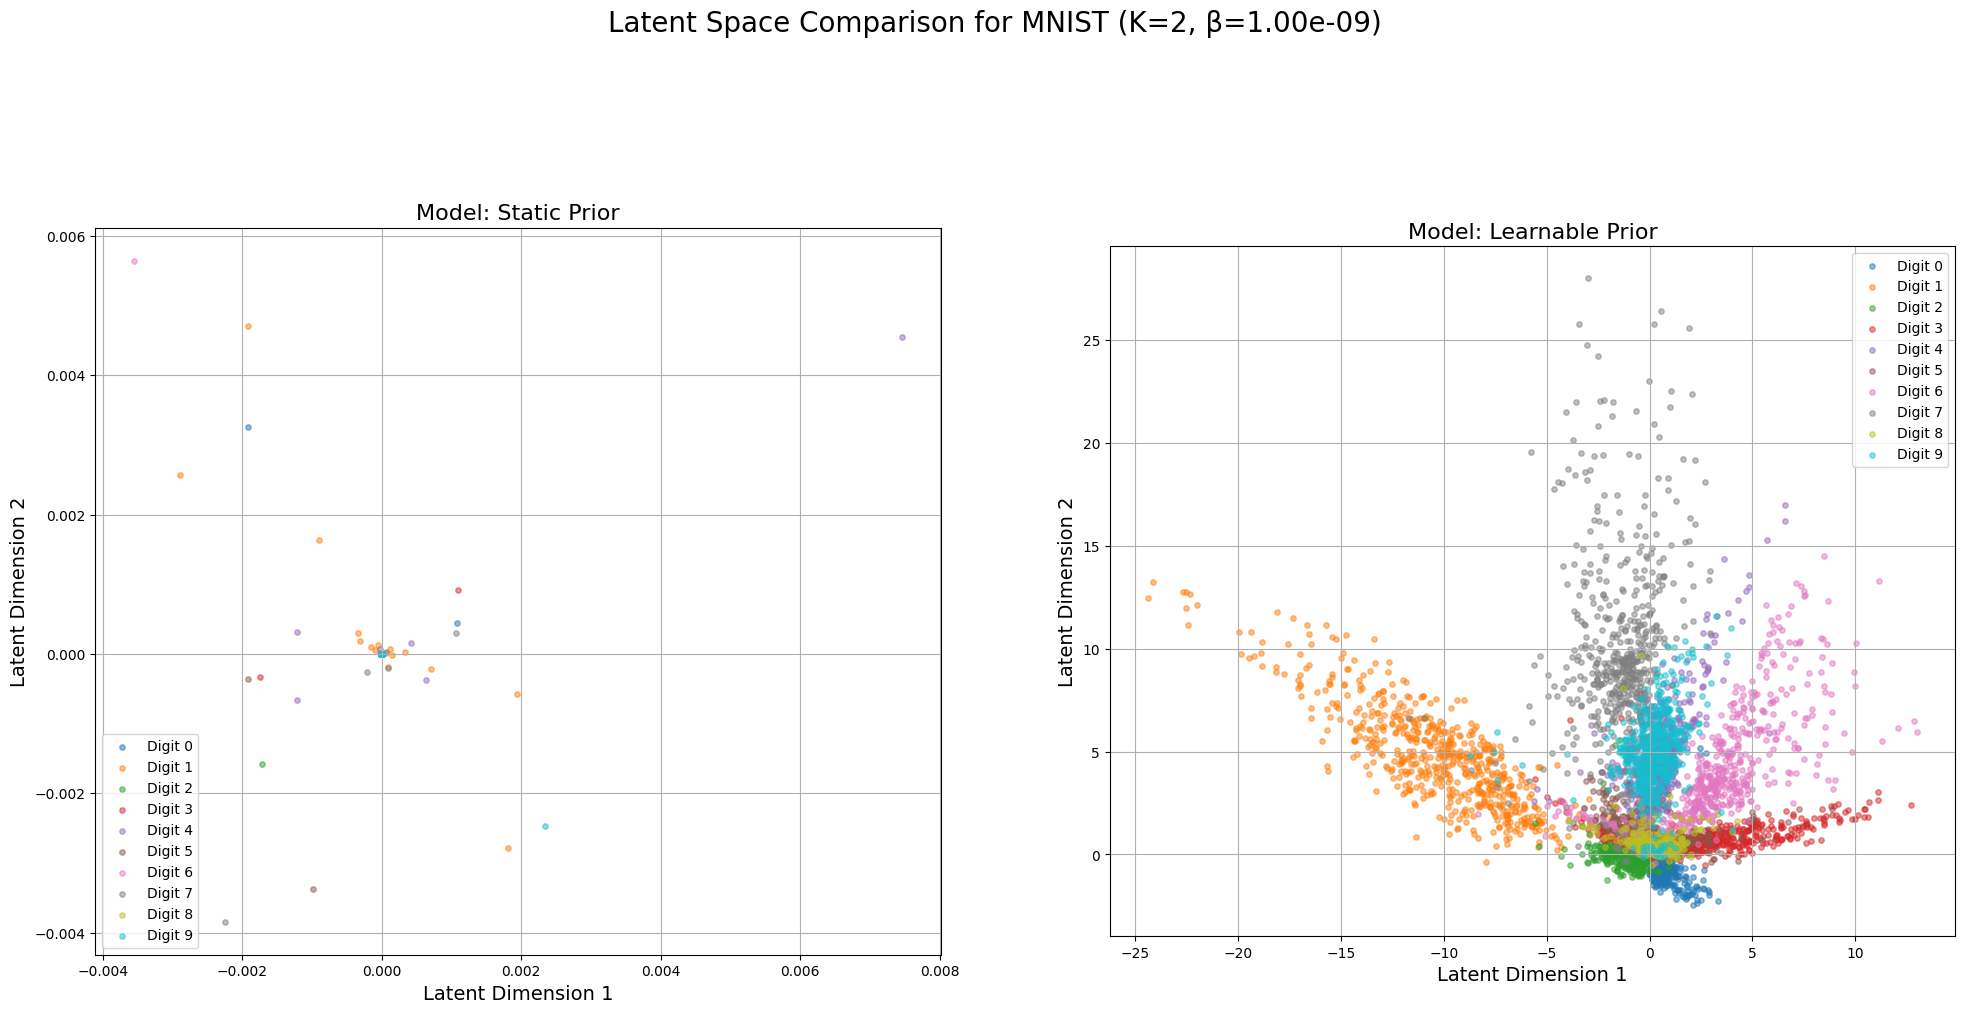

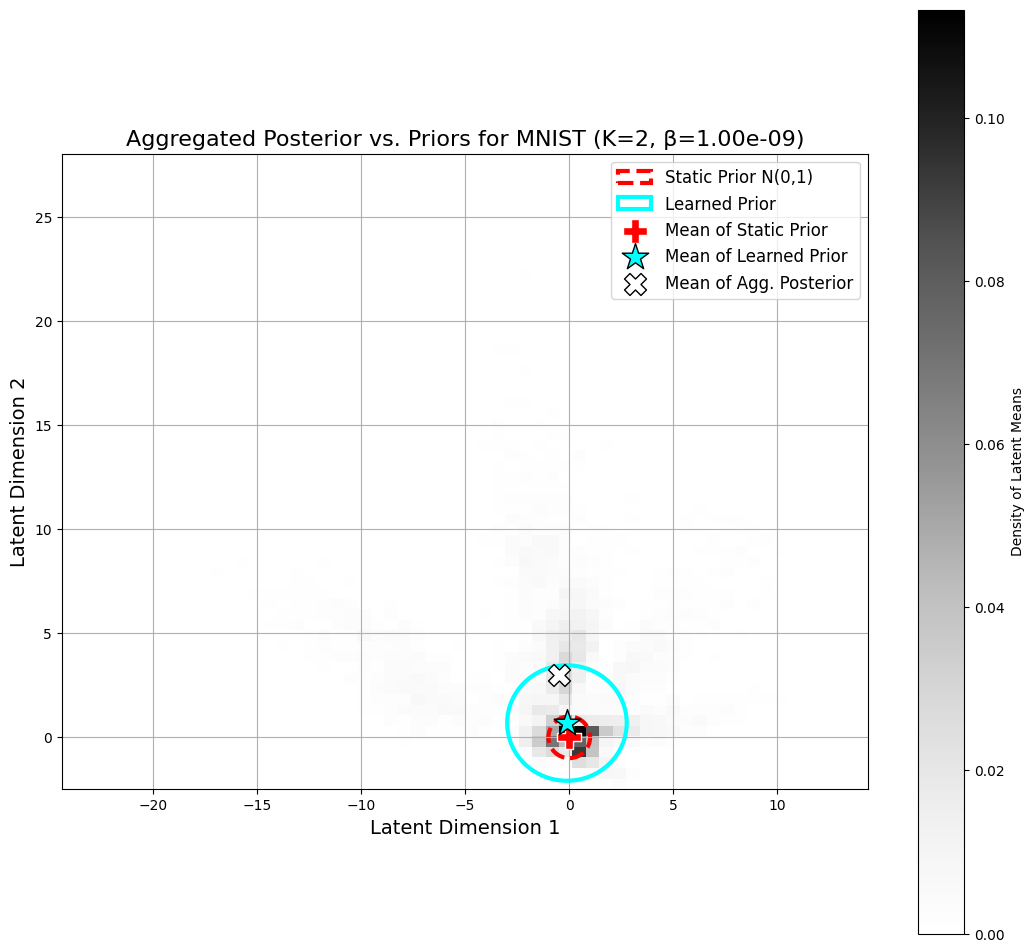

Dataset=MNIST, K=2, Model=learnable:   9%|▉         | 1/11 [02:41<26:55, 161.57s/it]


  Final Learned Prior (K=2, β=1.0e-08) -> Mu: [-1.51  1.25], Sigma: [2.47 1.03]

Generating comparison plots for K=2, beta=1.00e-08 on MNIST...
--> Plotting 5376 data points for the Static model.
--> Plotting 5376 data points for the Learnable model.


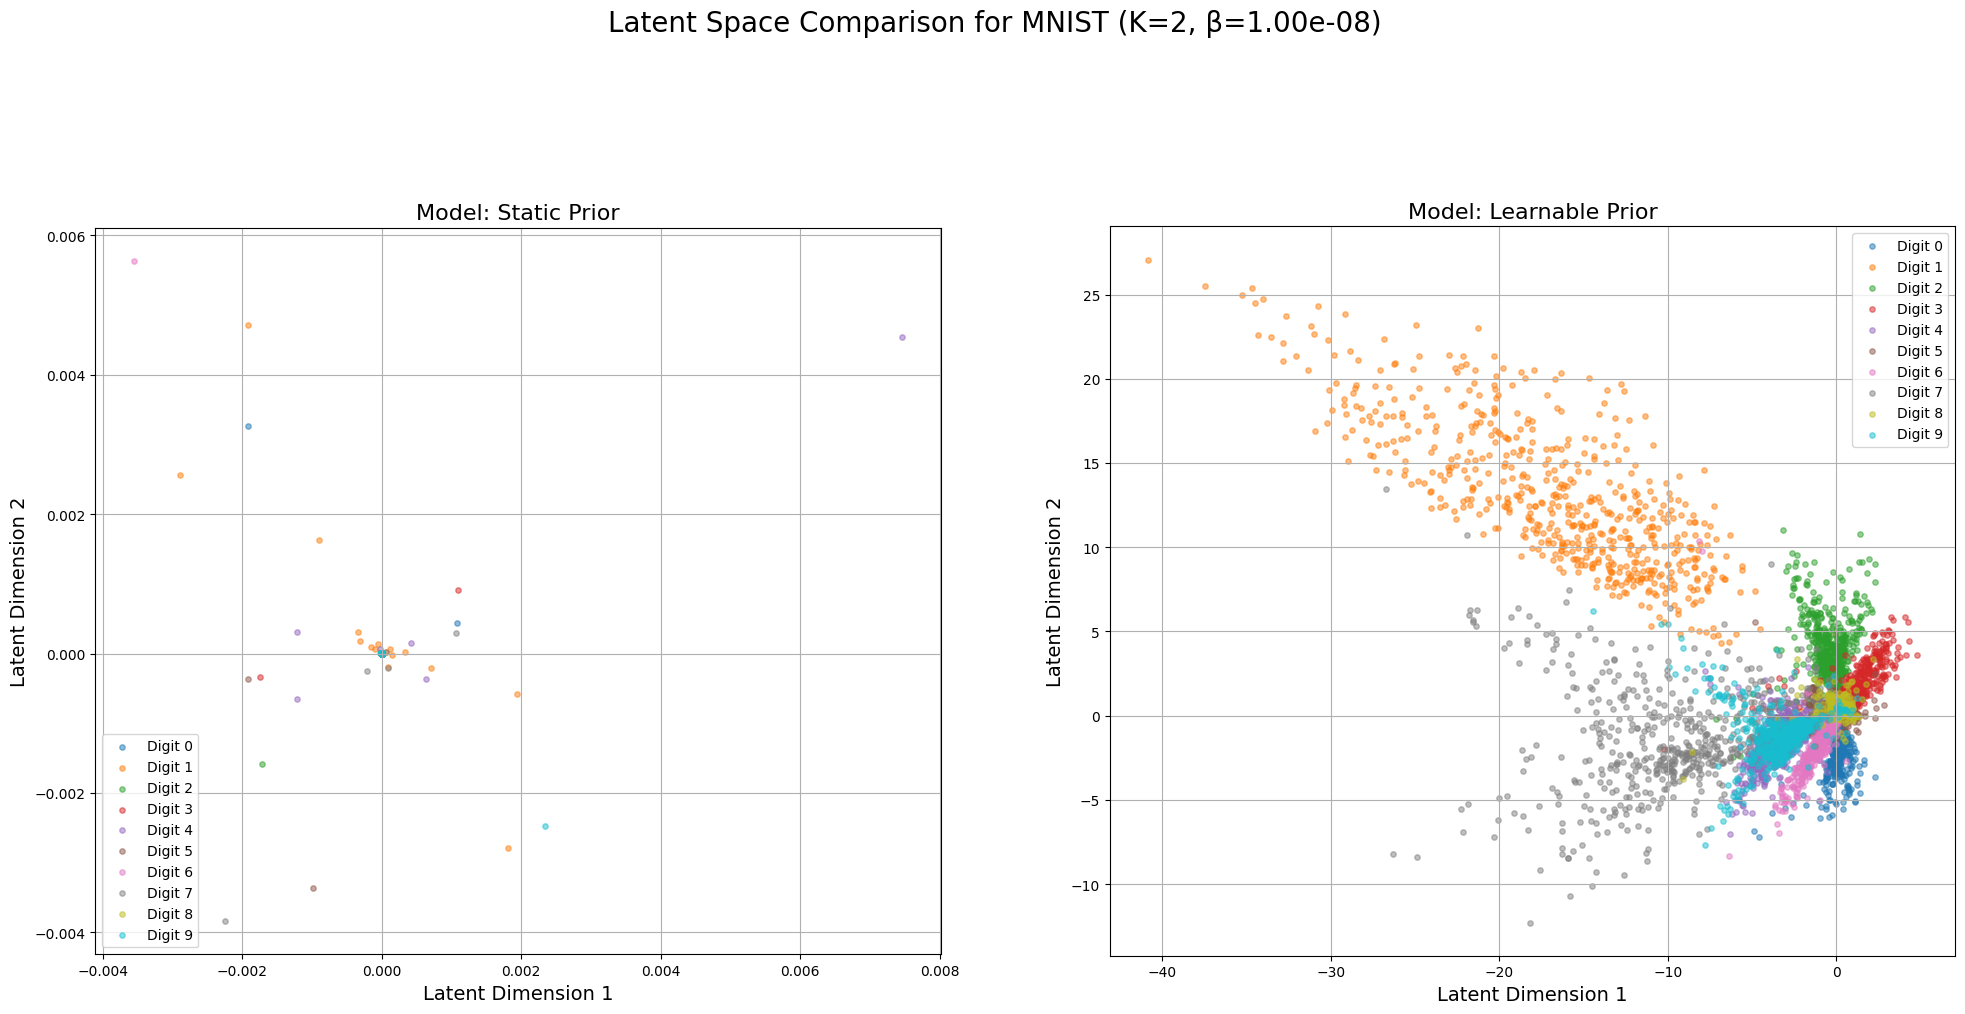

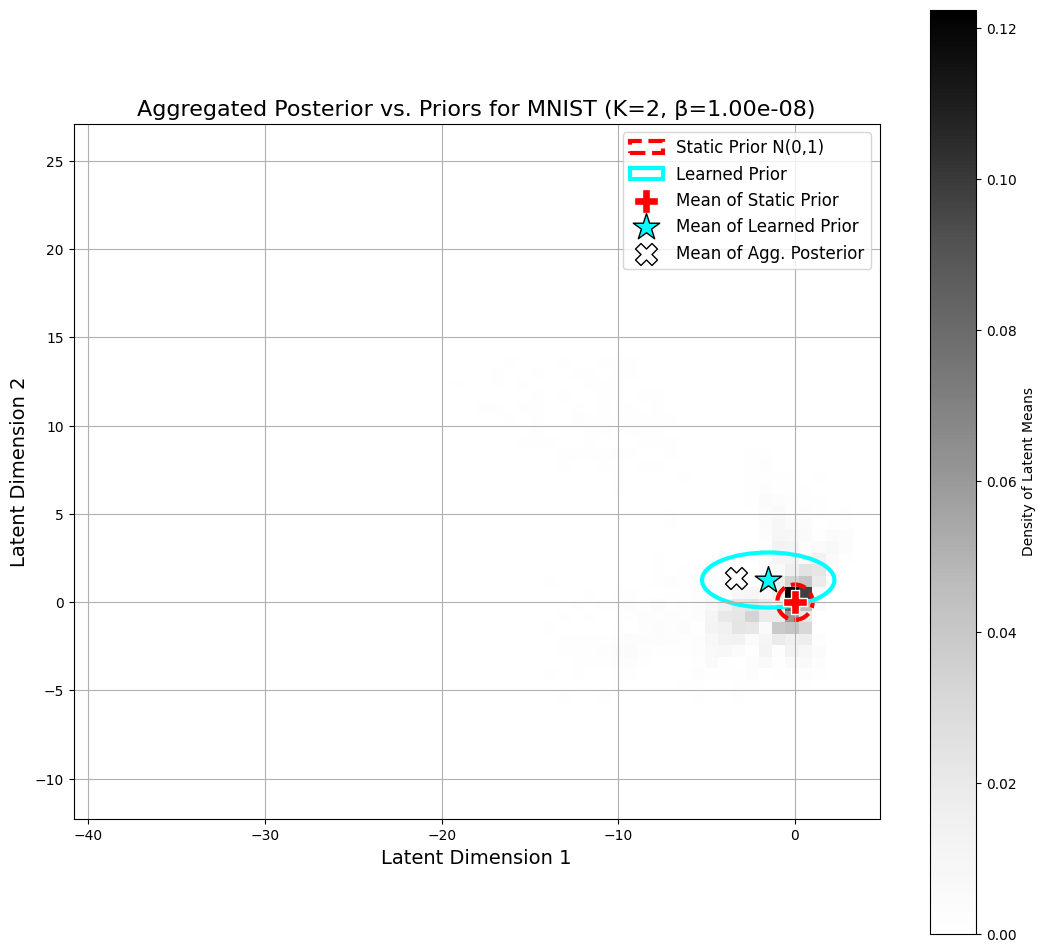

Dataset=MNIST, K=2, Model=learnable:  18%|█▊        | 2/11 [05:23<24:16, 161.80s/it]


  Final Learned Prior (K=2, β=1.0e-07) -> Mu: [-1.32 -1.97], Sigma: [2.87 1.81]

Generating comparison plots for K=2, beta=1.00e-07 on MNIST...
--> Plotting 5376 data points for the Static model.
--> Plotting 5376 data points for the Learnable model.


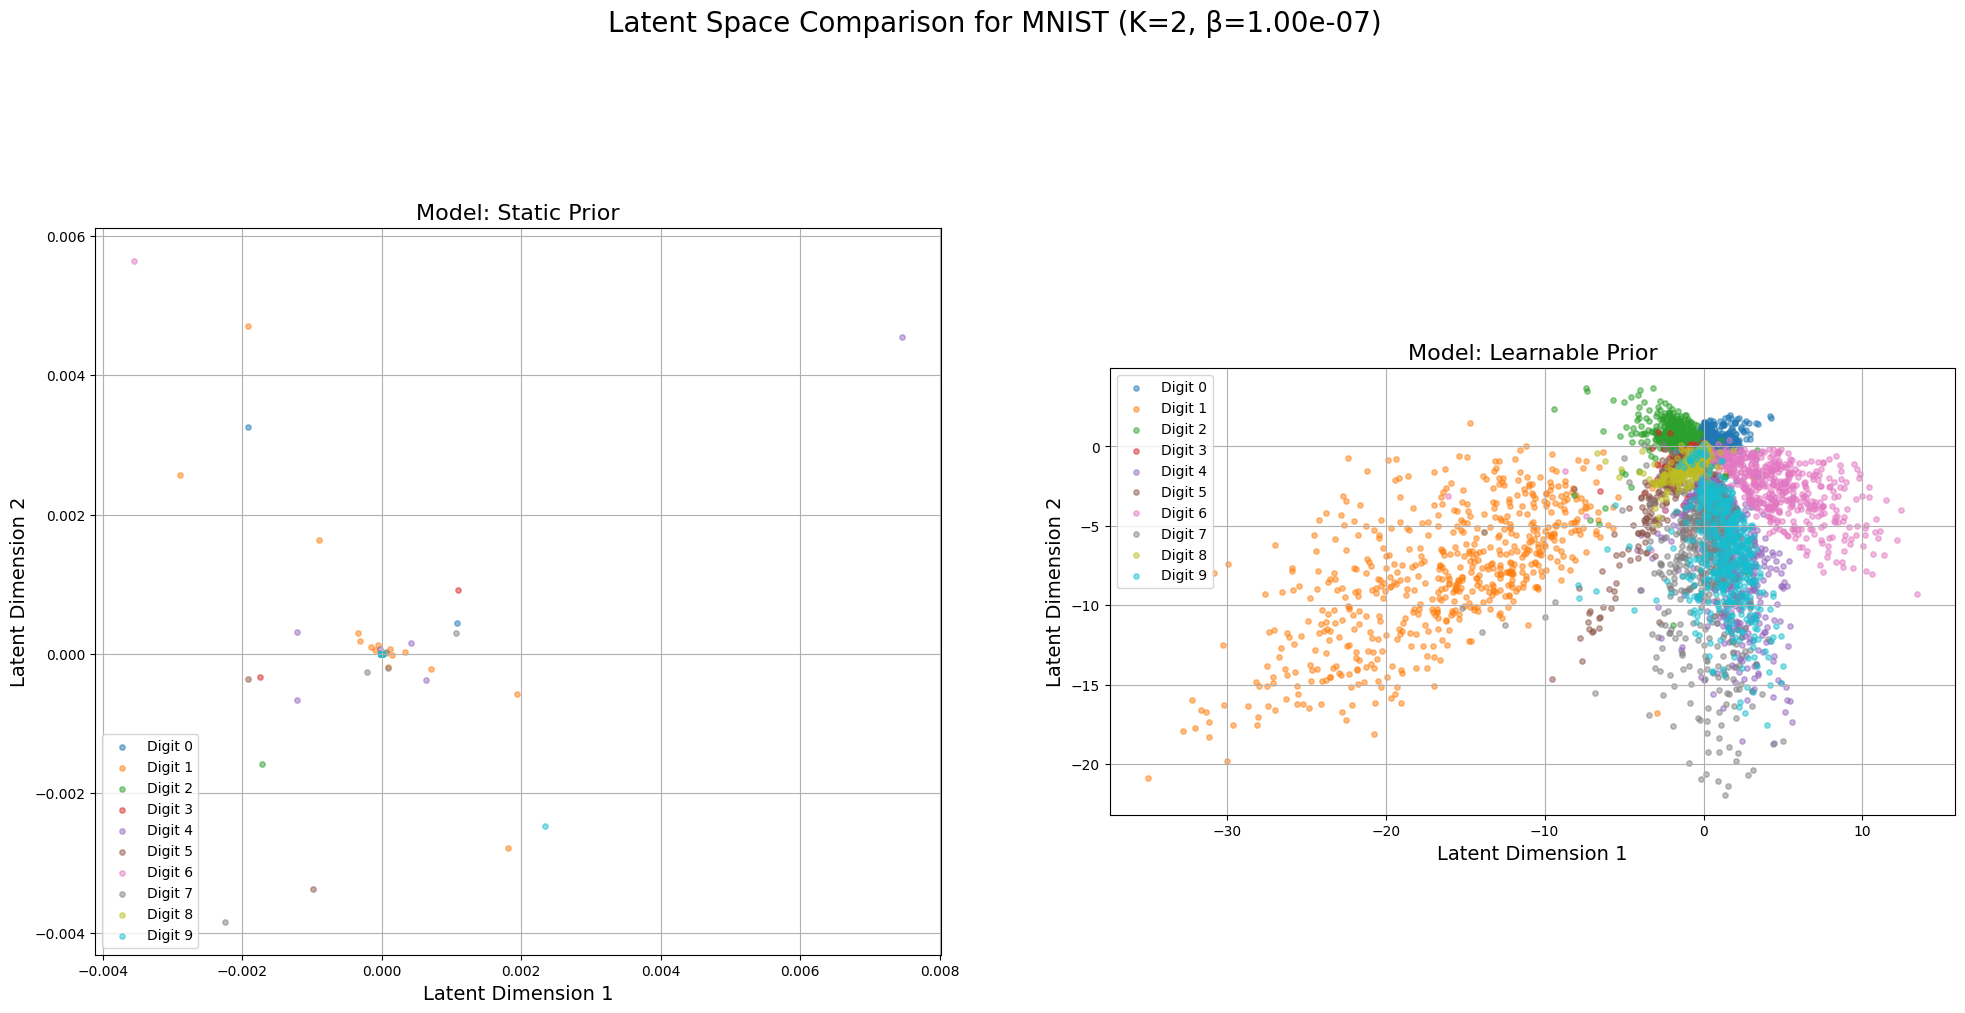

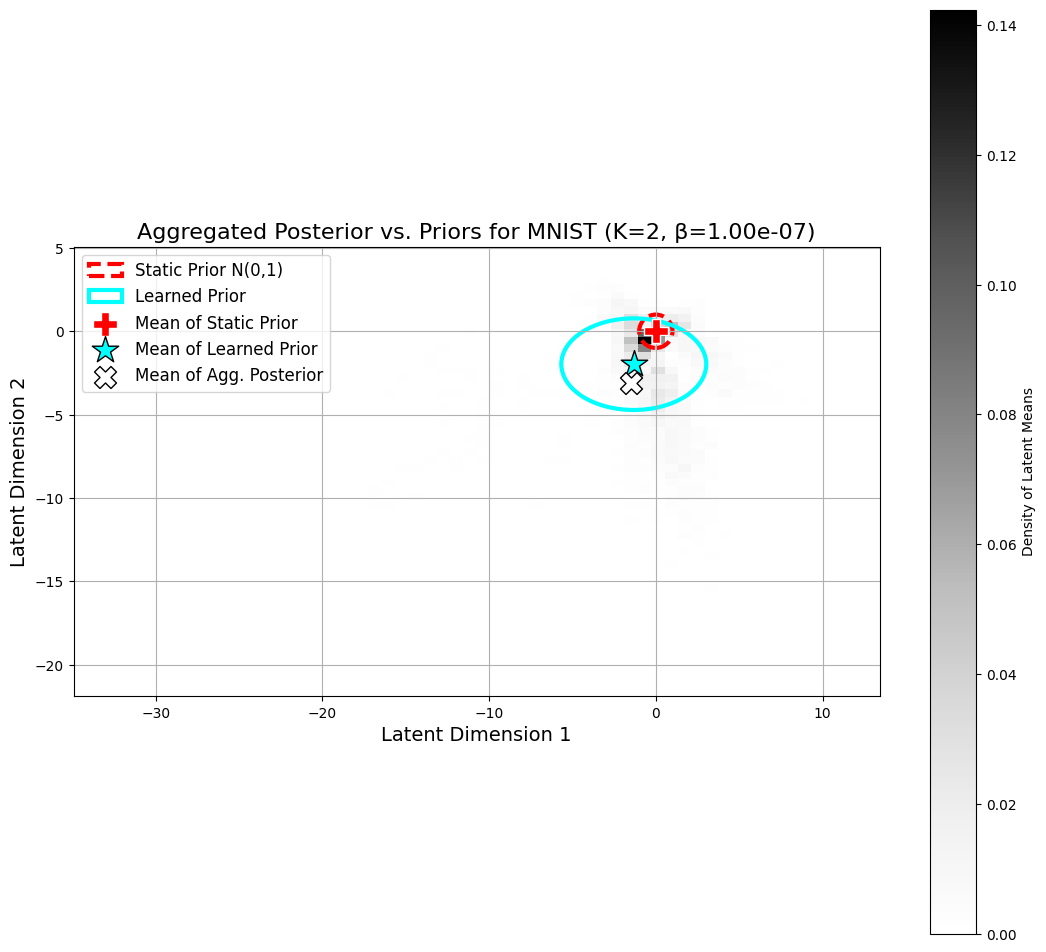

Dataset=MNIST, K=2, Model=learnable:  27%|██▋       | 3/11 [08:04<21:30, 161.32s/it]


  Final Learned Prior (K=2, β=1.0e-06) -> Mu: [1.59 1.74], Sigma: [2.21 2.17]

Generating comparison plots for K=2, beta=1.00e-06 on MNIST...
--> Plotting 5376 data points for the Static model.
--> Plotting 5376 data points for the Learnable model.


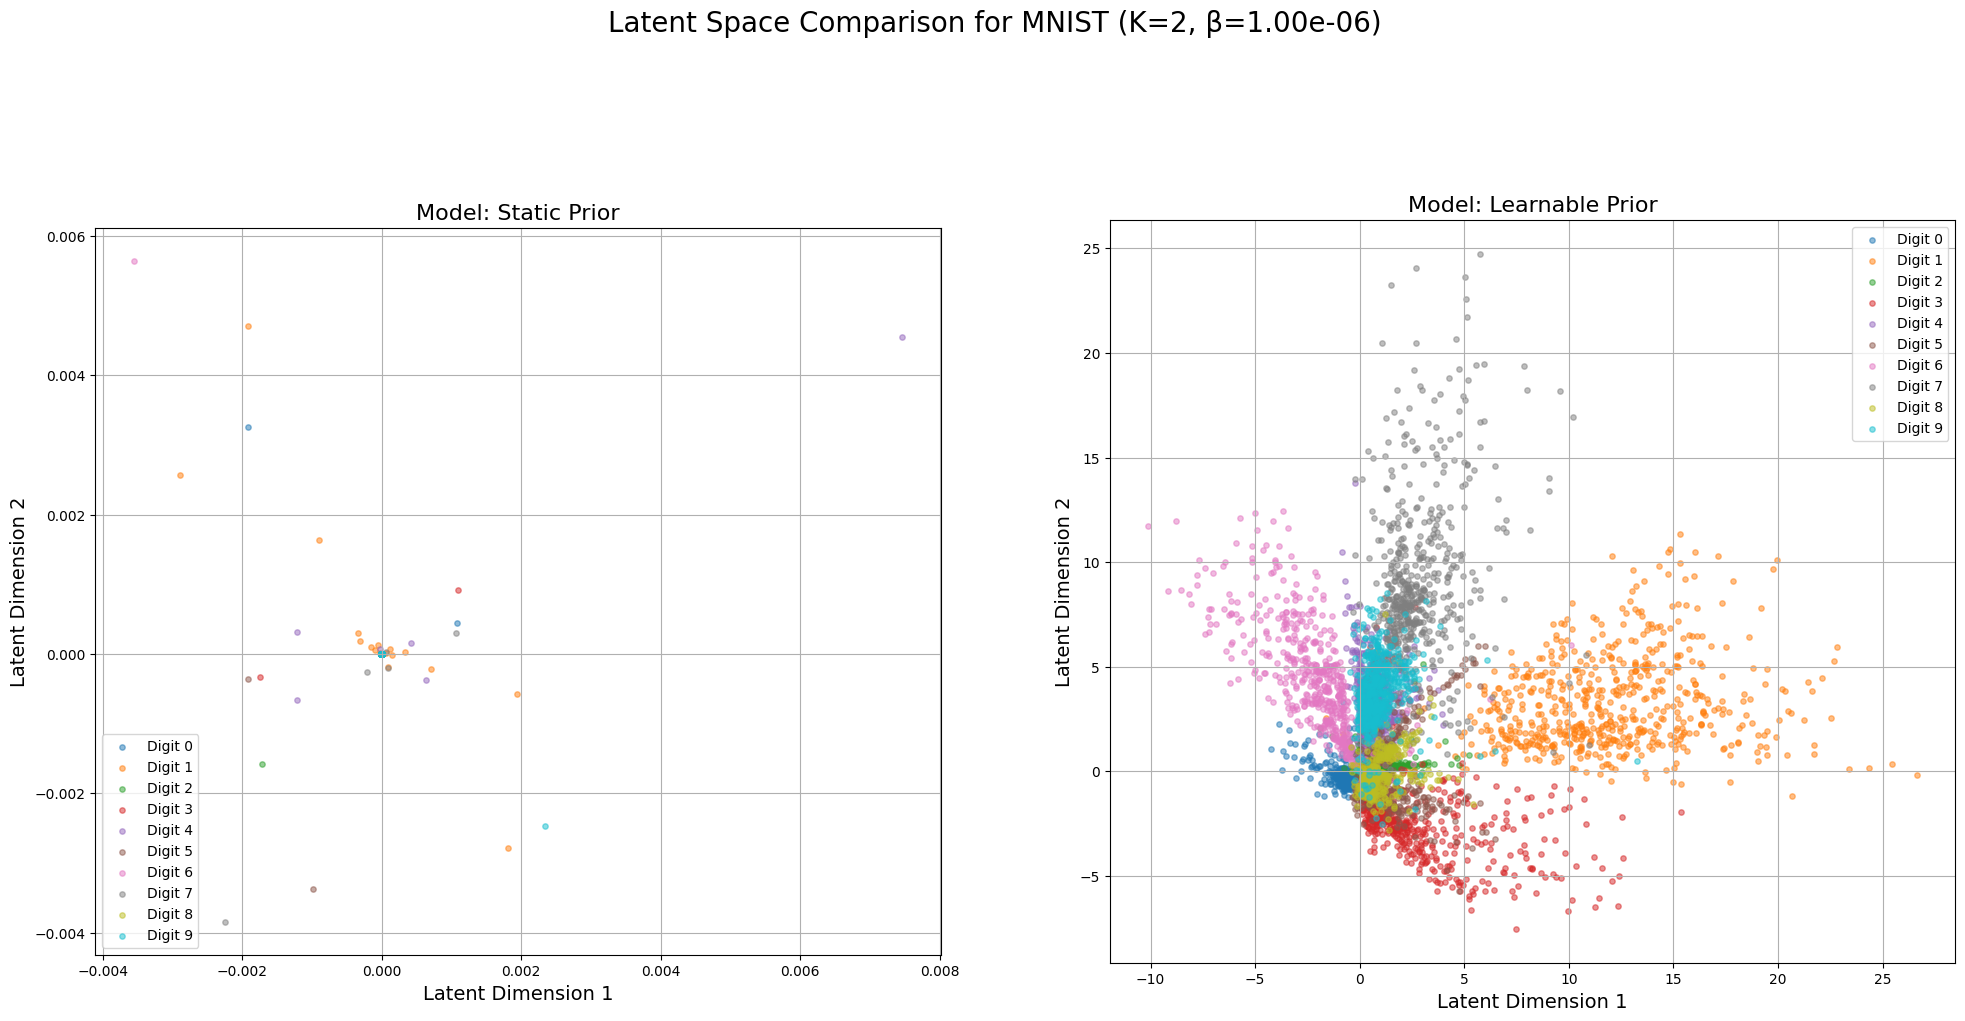

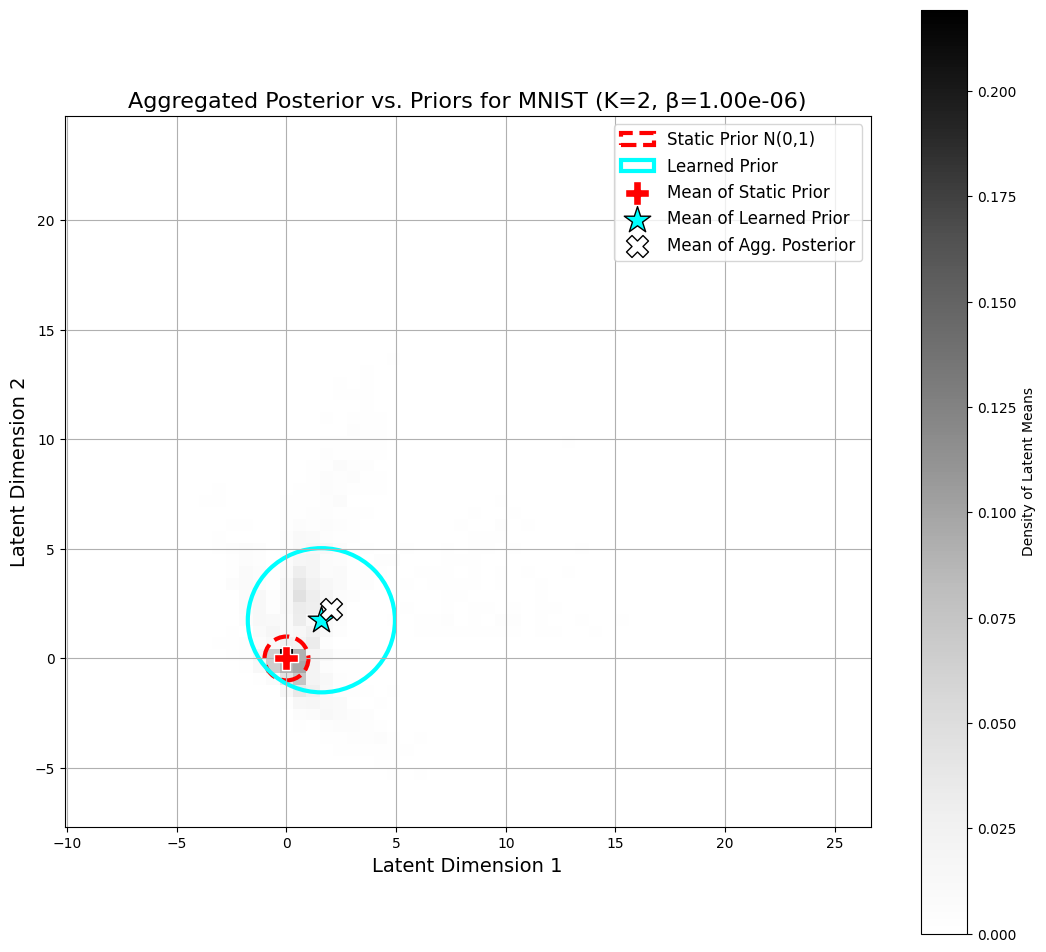

Dataset=MNIST, K=2, Model=learnable:  36%|███▋      | 4/11 [10:44<18:47, 161.00s/it]


  Final Learned Prior (K=2, β=1.0e-05) -> Mu: [ 1.57 -0.24], Sigma: [2.29 1.36]

Generating comparison plots for K=2, beta=1.00e-05 on MNIST...
--> Plotting 5376 data points for the Static model.
--> Plotting 5376 data points for the Learnable model.


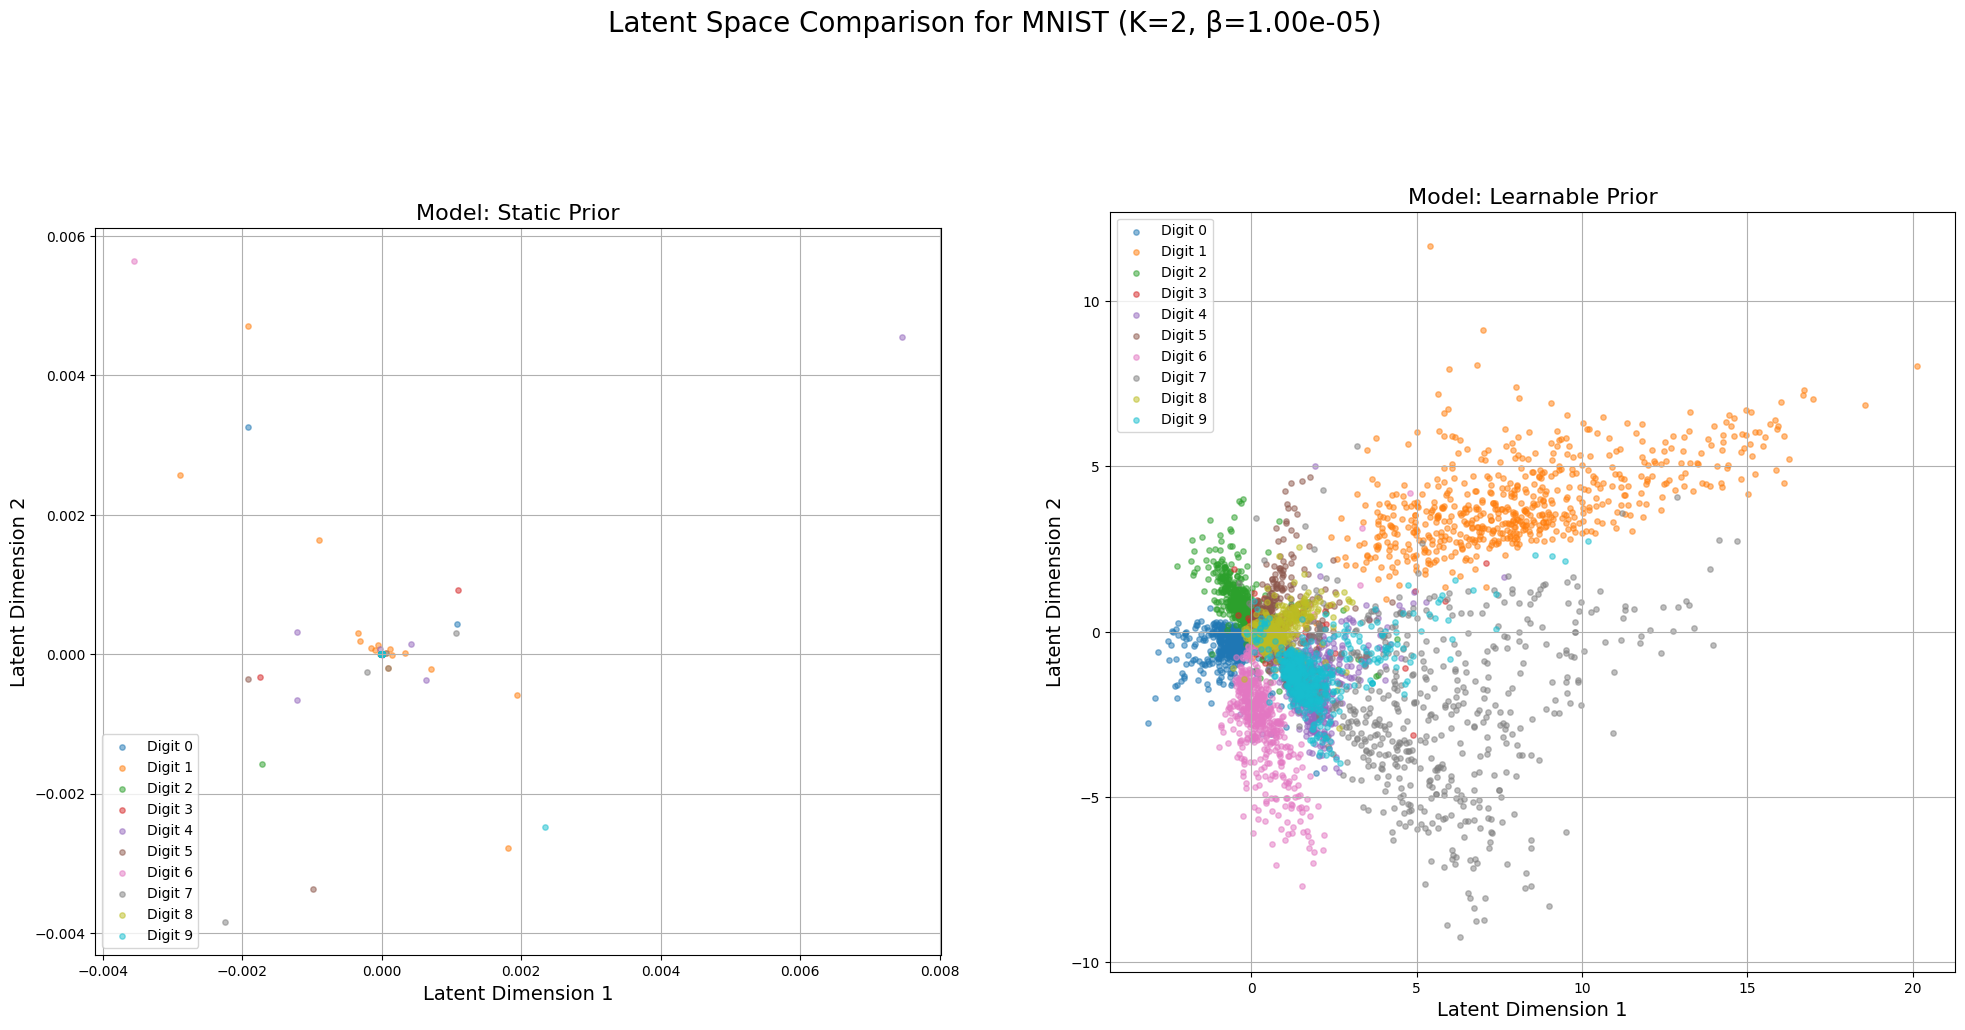

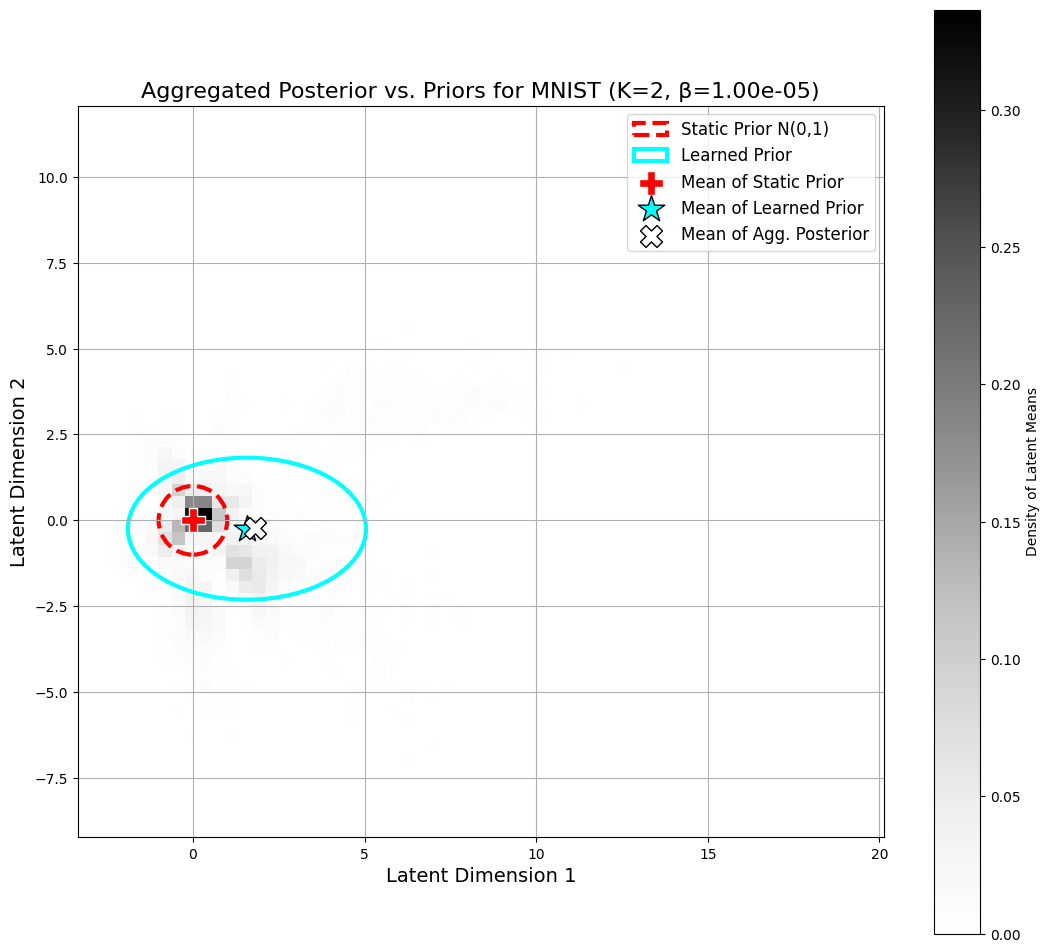

Dataset=MNIST, K=2, Model=learnable:  45%|████▌     | 5/11 [13:24<16:03, 160.60s/it]


  Final Learned Prior (K=2, β=1.0e-04) -> Mu: [0.44 0.11], Sigma: [1.16 1.41]

Generating comparison plots for K=2, beta=1.00e-04 on MNIST...
--> Plotting 5376 data points for the Static model.
--> Plotting 5376 data points for the Learnable model.


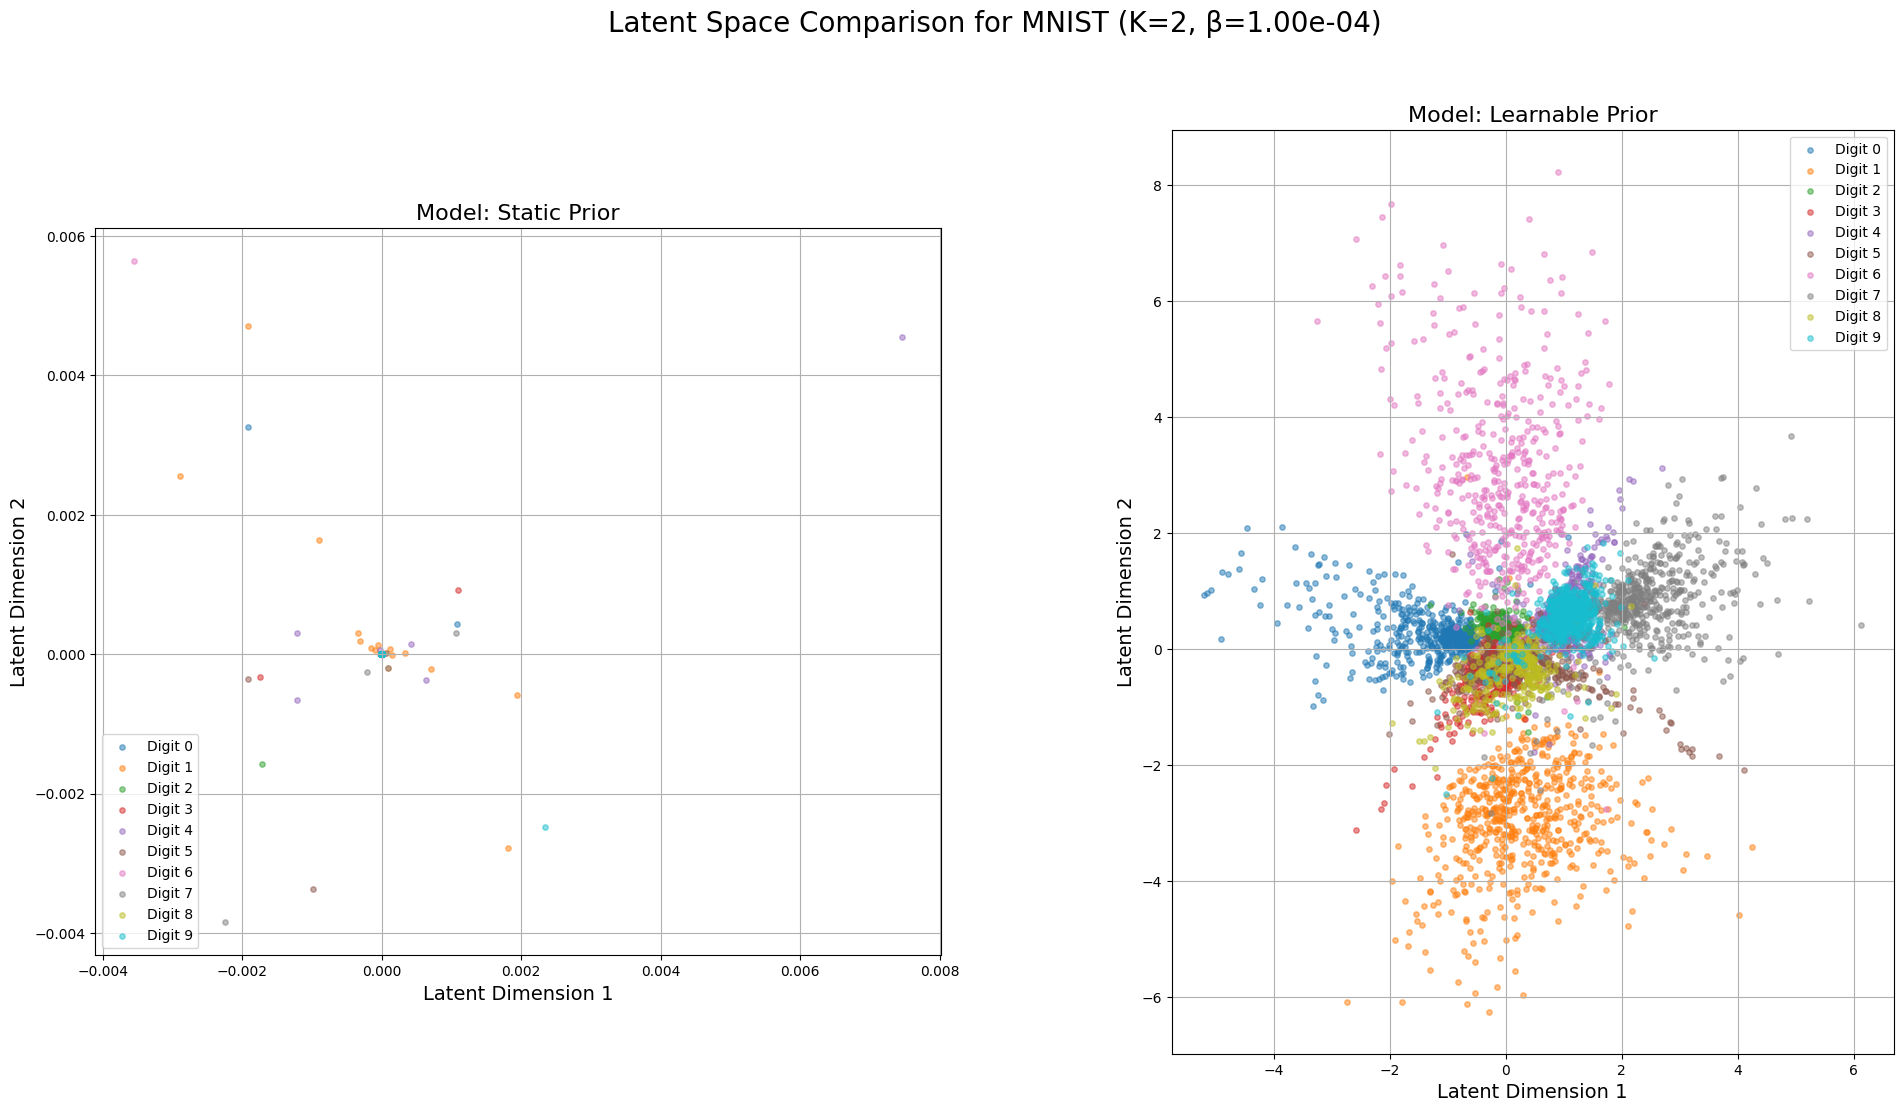

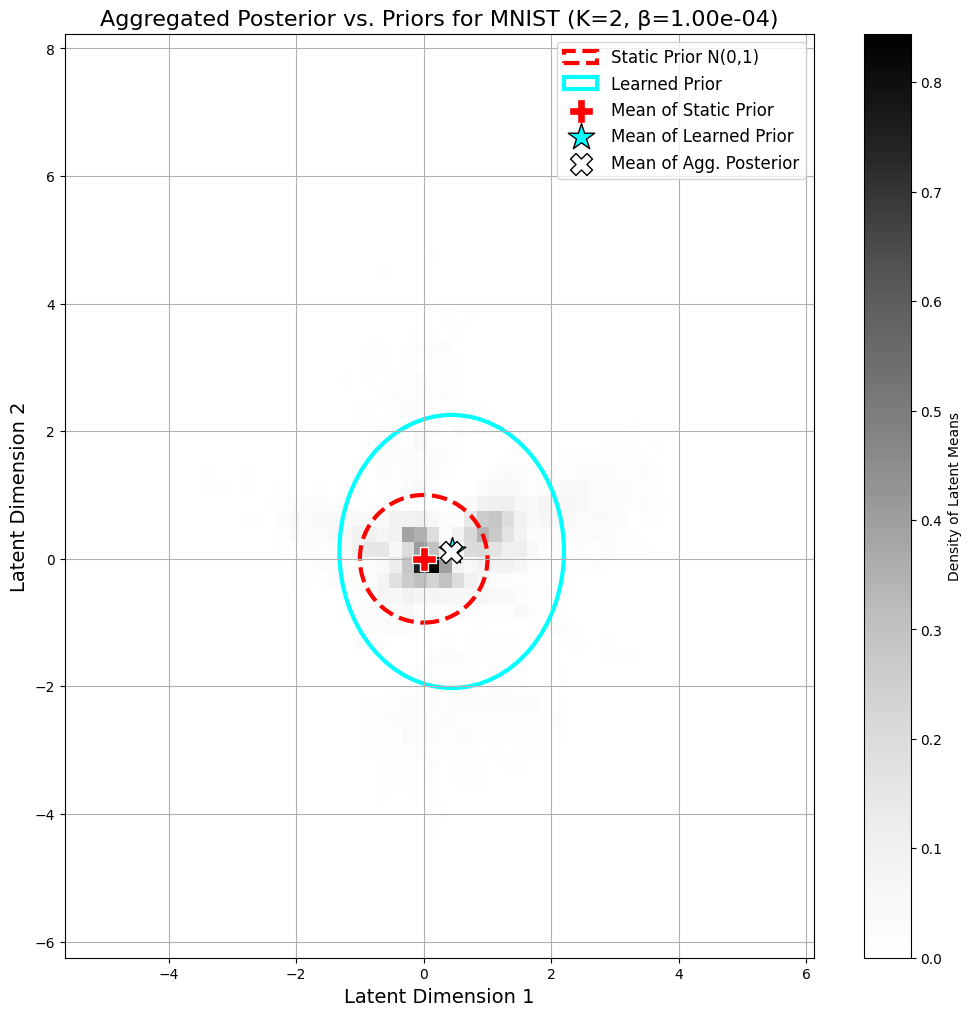

Dataset=MNIST, K=2, Model=learnable:  55%|█████▍    | 6/11 [16:05<13:24, 160.83s/it]


  Final Learned Prior (K=2, β=1.0e-03) -> Mu: [ 0.15 -0.01], Sigma: [1.09 1.02]

Generating comparison plots for K=2, beta=1.00e-03 on MNIST...
--> Plotting 5376 data points for the Static model.
--> Plotting 5376 data points for the Learnable model.


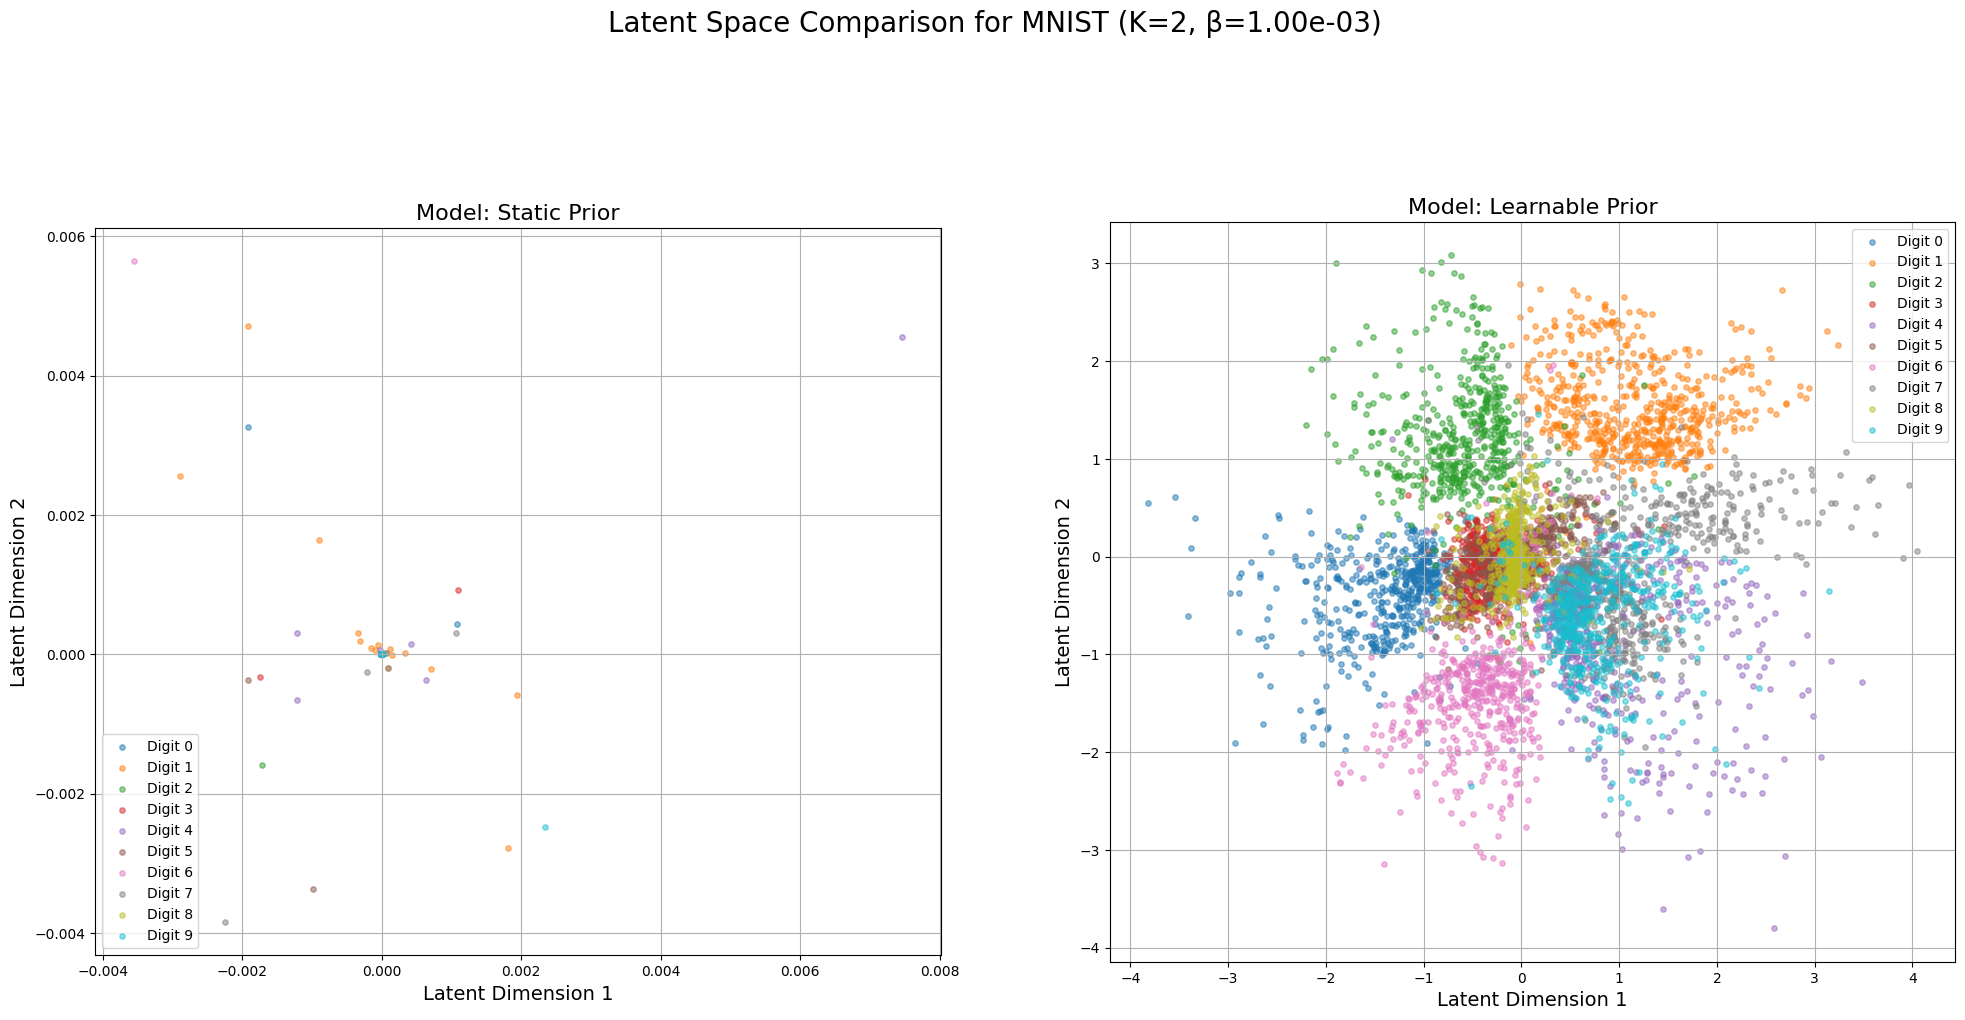

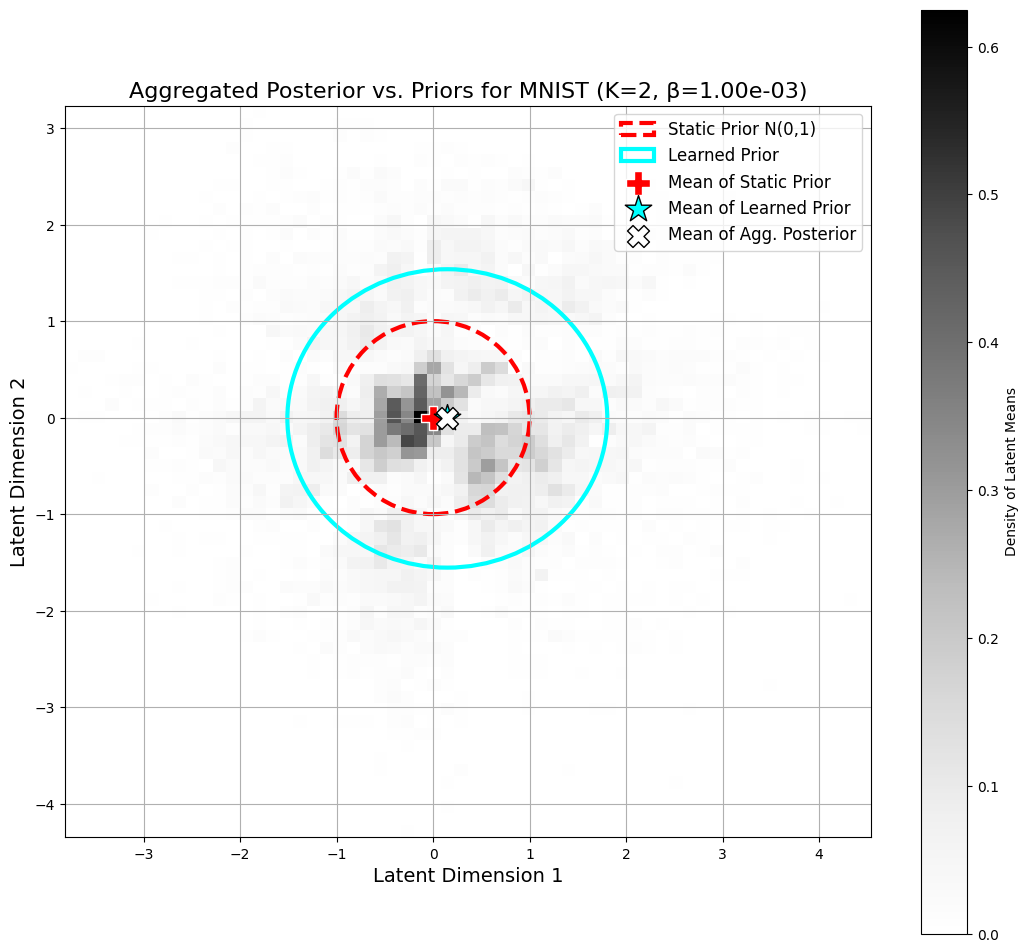

Dataset=MNIST, K=2, Model=learnable:  64%|██████▎   | 7/11 [18:46<10:42, 160.69s/it]


  Final Learned Prior (K=2, β=1.0e-02) -> Mu: [ 0.03 -0.23], Sigma: [0.9  0.93]

Generating comparison plots for K=2, beta=1.00e-02 on MNIST...
--> Plotting 5376 data points for the Static model.
--> Plotting 5376 data points for the Learnable model.


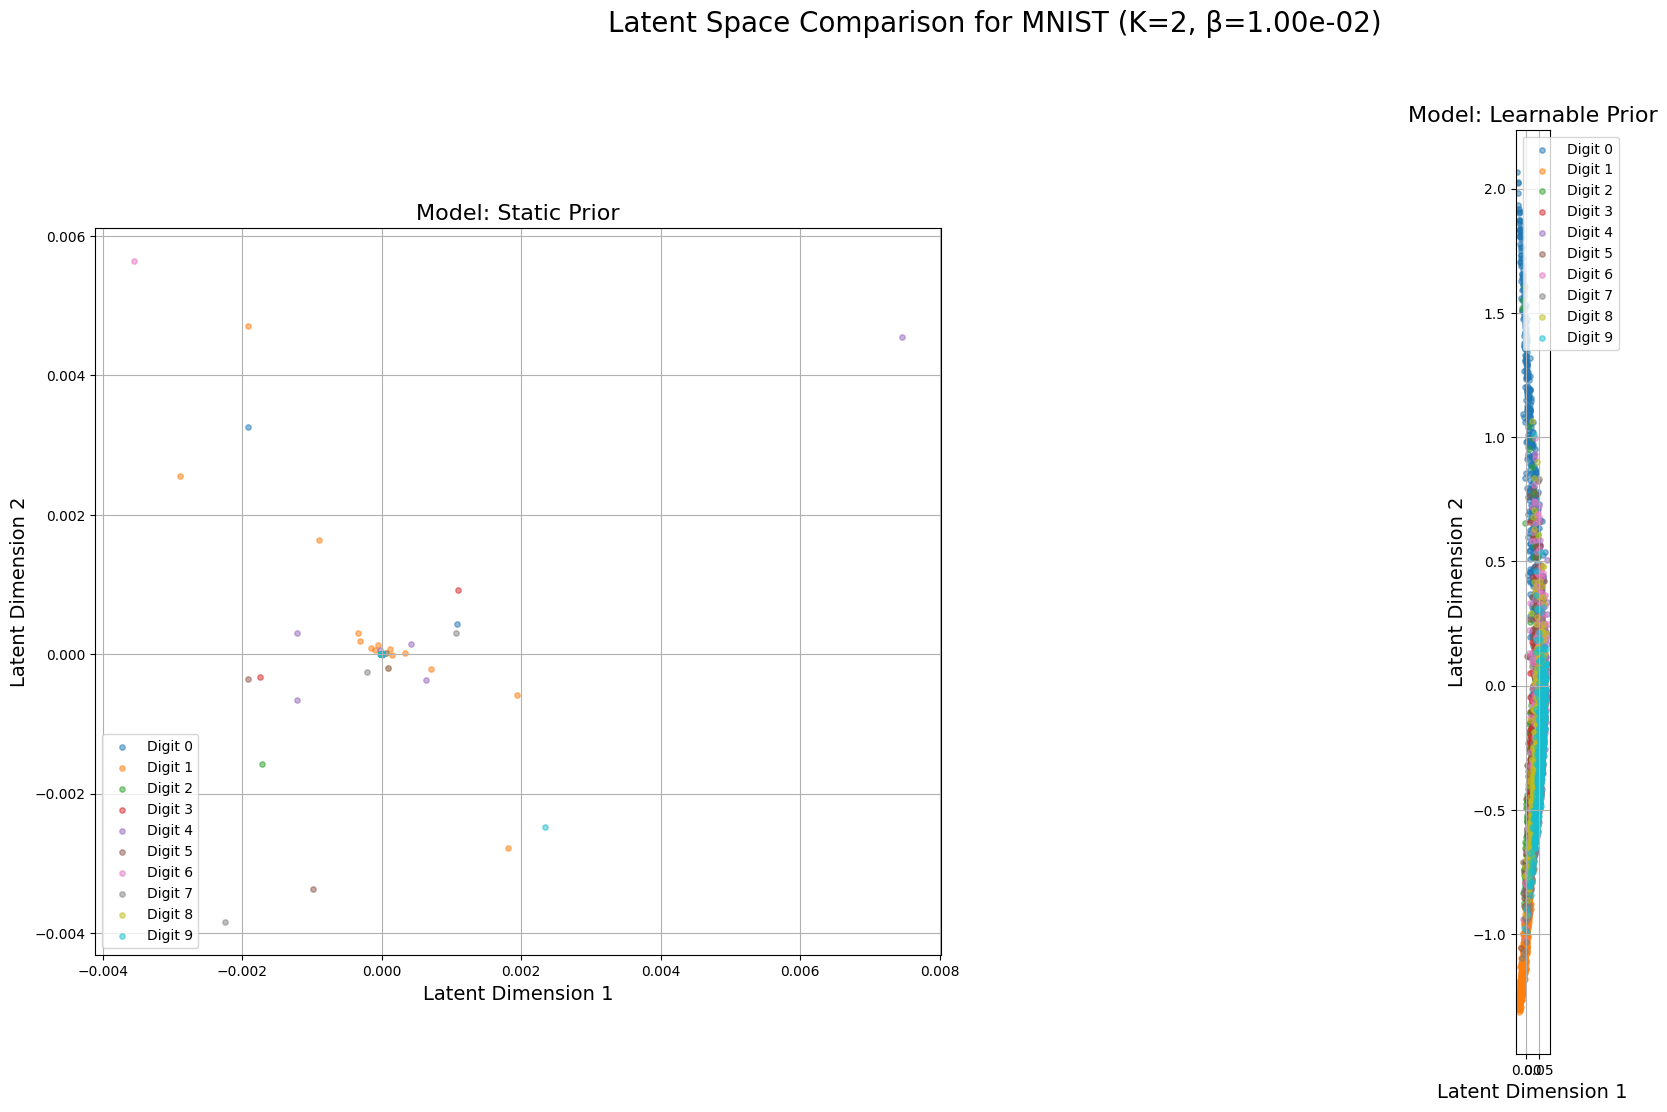

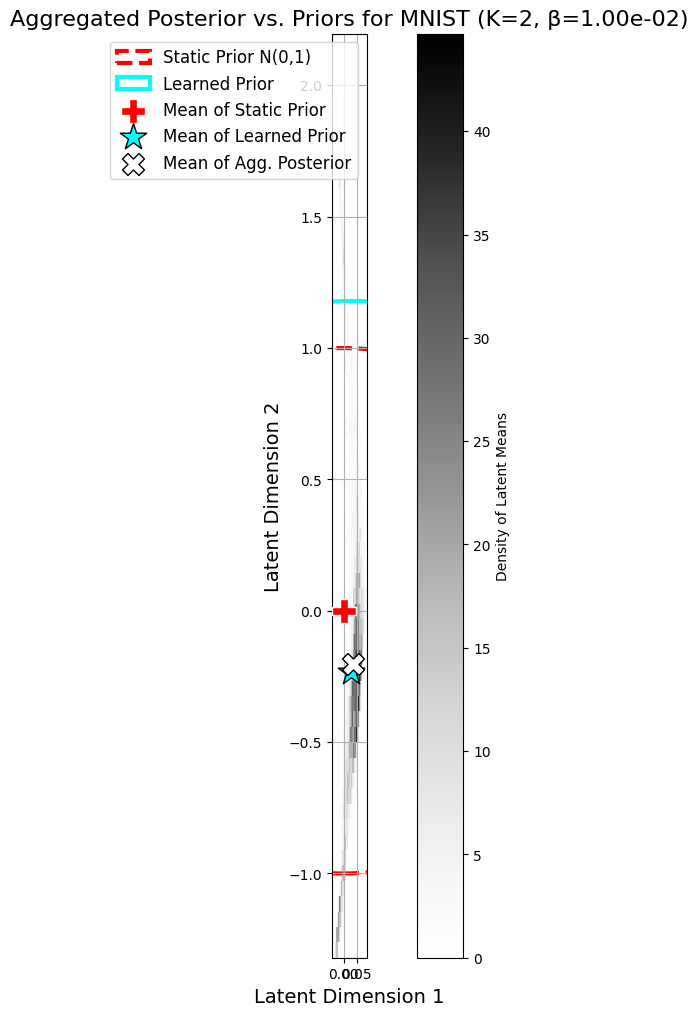

Dataset=MNIST, K=2, Model=learnable:  73%|███████▎  | 8/11 [21:28<08:03, 161.05s/it]

In [ ]:
def run_experiment():
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    DATASETS = ['MNIST', 'FashionMNIST']
    K_DIMS = [256, 2]
    BETAS = get_beta_values()
    EPOCHS = 20
    BATCH_SIZE = 256
    LEARNING_RATE = 1e-3
    MODEL_TYPES = {'static': VAE_CNN, 'learnable': VAE_LearnablePrior}

    results = []

    for dataset_name in DATASETS:
        print(f"\n{'='*20} Running Experiment for: {dataset_name.upper()} {'='*20}")
        train_loader, test_loader = get_data_loaders(dataset_name, BATCH_SIZE)

        static_model_for_comparison = None

        for model_name, model_class in MODEL_TYPES.items():
            for k_dim in K_DIMS:
                for beta in tqdm(BETAS, desc=f"Dataset={dataset_name}, K={k_dim}, Model={model_name}"):
                    model = model_class(k_dim=k_dim, nc=1).to(DEVICE)
                    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
                    for epoch in range(EPOCHS):
                        train_one_epoch(model, optimizer, train_loader, beta, DEVICE)

                    if model_name == 'learnable':
                        mu_p = model.prior_mu.detach().cpu().numpy()
                        sigma_p = torch.exp(0.5 * model.prior_logvar).detach().cpu().numpy()
                        print(f"\n  Final Learned Prior (K={k_dim}, β={beta:.1e}) -> Mu: {np.round(mu_p, 2)}, Sigma: {np.round(sigma_p, 2)}")

                    if k_dim == 2:
                        if model_name == 'static':
                            static_model_for_comparison = model # Save the trained static model
                        elif model_name == 'learnable' and static_model_for_comparison is not None:
                            print(f"\nGenerating comparison plots for K=2, beta={beta:.2e} on {dataset_name}...")
                            plot_latent_space_comparison(static_model_for_comparison, model, test_loader, DEVICE, beta, dataset_name)
                            plot_aggregated_posterior_vs_priors(model, test_loader, DEVICE, beta, dataset_name)

                    train_metrics = evaluate(model, train_loader, beta, DEVICE)
                    test_metrics = evaluate(model, test_loader, beta, DEVICE)
                    res_row = {'dataset': dataset_name, 'model_type': model_name, 'k_dim': k_dim, 'beta': beta}
                    res_row.update({f'train_{k}': v for k, v in train_metrics.items()})
                    res_row.update({f'test_{k}': v for k, v in test_metrics.items()})
                    results.append(res_row)

    return pd.DataFrame(results)

def plot_results(df, eval_type='avg'):
    metric_key = 'mse_avg' if eval_type == 'avg' else 'mse_1_shot'
    title_suffix = 'Avg MSE' if eval_type == 'avg' else '1-Shot MSE'

    for dataset_name in df['dataset'].unique():
        fig, axes = plt.subplots(2, 2, figsize=(18, 14))
        fig.suptitle(f'VIB Auto-Encoder Comparison for {dataset_name} ({title_suffix})', fontsize=20)

        df_dataset = df[df['dataset'] == dataset_name]
        df_static = df_dataset[df_dataset['model_type'] == 'static']
        df_learnable = df_dataset[df_dataset['model_type'] == 'learnable']

        for i, k_dim in enumerate([256, 2]):
            ax = axes[0, i]
            df_k_static = df_static[df_static['k_dim'] == k_dim]
            df_k_learnable = df_learnable[df_learnable['k_dim'] == k_dim]

            if not df_k_static.empty:
                ax.plot(df_k_static['beta'], df_k_static[f'test_{metric_key}'], 'o-', color='C0', label=f'Static - Test {title_suffix}')
                ax.plot(df_k_static['beta'], df_k_static[f'train_{metric_key}'], 'o--', color='C0', alpha=0.7, label=f'Static - Train {title_suffix}')
            if not df_k_learnable.empty:
                ax.plot(df_k_learnable['beta'], df_k_learnable[f'test_{metric_key}'], 's-', color='C1', label=f'Learnable - Test {title_suffix}')
                ax.plot(df_k_learnable['beta'], df_k_learnable[f'train_{metric_key}'], 's--', color='C1', alpha=0.7, label=f'Learnable - Train {title_suffix}')

            ax.set_xscale('log'); ax.set_yscale('log')
            ax.set_title(f'({chr(97+i)}) {title_suffix} vs. β for K={k_dim}', fontsize=16)
            ax.set_xlabel('β', fontsize=14); ax.set_ylabel(f'Distortion ({title_suffix})', fontsize=14)
            ax.grid(True, which="both", ls="--"); ax.legend(fontsize=12)

        df_k1_static = df_static[df_static['k_dim'] == 256]
        df_k1_learnable = df_learnable[df_learnable['k_dim'] == 256]

        ax = axes[1, 0]
        if not df_k1_static.empty:
            ax.plot(df_k1_static['test_i_x_z'], -df_k1_static[f'test_{metric_key}'], 'o-', color='C0', label='Static - Test')
            ax.plot(df_k1_static['train_i_x_z'], -df_k1_static[f'train_{metric_key}'], 'o--', color='C0', alpha=0.7, label='Static - Train')
        if not df_k1_learnable.empty:
            ax.plot(df_k1_learnable['test_i_x_z'], -df_k1_learnable[f'test_{metric_key}'], 's-', color='C1', label='Learnable - Test')
            ax.plot(df_k1_learnable['train_i_x_z'], -df_k1_learnable[f'train_{metric_key}'], 's--', color='C1', alpha=0.7, label='Learnable - Train')
        ax.set_title('(c) Rate-Distortion Plane for K=256', fontsize=16)
        ax.set_xlabel('Rate: I(X; Z)', fontsize=14); ax.set_ylabel(f'Relevance: -{title_suffix}', fontsize=14)
        ax.grid(True, which="both", ls="--"); ax.legend(fontsize=12)

        ax = axes[1, 1]
        if not df_k1_static.empty:
            ax.plot(df_k1_static['beta'], df_k1_static['test_i_x_z'], 'o-', color='C0', label='Static - Test')
            ax.plot(df_k1_static['beta'], df_k1_static['train_i_x_z'], 'o--', color='C0', alpha=0.7, label='Static - Train')
        if not df_k1_learnable.empty:
            ax.plot(df_k1_learnable['beta'], df_k1_learnable['test_i_x_z'], 's-', color='C1', label='Learnable - Test')
            ax.plot(df_k1_learnable['beta'], df_k1_learnable['train_i_x_z'], 's--', color='C1', alpha=0.7, label='Learnable - Train')
        ax.set_xscale('log'); ax.set_yscale('log')
        ax.set_title('(d) Rate I(X; Z) vs. β for K=256', fontsize=16)
        ax.set_xlabel('β', fontsize=14); ax.set_ylabel('Rate: I(X; Z)', fontsize=14)
        ax.grid(True, which="both", ls="--"); ax.legend(fontsize=12)

        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.show()


results_df = run_experiment()
results_df.to_csv('vib_autoencoder_results_combined.csv', index=False)
plot_results(results_df, eval_type='avg')
plot_results(results_df, eval_type='1_shot')